In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

# библиотеки для потстроения моделей ML

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold) 

from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# импортируем метрики качества
from sklearn.metrics import (recall_score, 
                             confusion_matrix)


In [2]:
from pandas_profiling import ProfileReport

Изучим предоставленный датасет

In [52]:
heart = pd.read_csv("train.csv")
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955 entries, 0 to 954
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     955 non-null    object 
 1   Пол                                    954 non-null    object 
 2   Семья                                  955 non-null    object 
 3   Этнос                                  955 non-null    object 
 4   Национальность                         955 non-null    object 
 5   Религия                                955 non-null    object 
 6   Образование                            955 non-null    object 
 7   Профессия                              955 non-null    object 
 8   Вы работаете?                          955 non-null    int64  
 9   Выход на пенсию                        955 non-null    int64  
 10  Прекращение работы по болезни          955 non-null    int64  
 11  Сахарн

In [39]:
heart.head(5)

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,...,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,...,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,...,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,...,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0


In [53]:
Заменим пропущенные значения в ряде столбцов на нули, а также создадим столбцы с часами пробуждения и засыпания. 

In [53]:
heart = heart.fillna(0)
heart[heart["Пол"] == 0]
heart = heart.drop(index=[304]).reset_index()

heart['Время засыпания'] = heart['Время засыпания'].astype('datetime64')
heart['Время пробуждения'] = heart['Время пробуждения'].astype('datetime64')

heart.insert(34, 'Час засыпания', heart['Время засыпания'].dt.hour, True)
heart.insert(35, 'Час пробуждения', heart['Время пробуждения'].dt.hour, True)

Для более детального изучения датасета воспользуемся библиотекой Pandas Profiling и получим подробный отчет о данных, 
включая расчет базовых статистик

In [91]:
report = ProfileReport(heart, title="Pandas Profiling Report")
report.to_file("my_report.html")
report.to_widgets()

Summarize dataset:   0%|          | 0/56 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
Добавим еще один признак - длительность сна

In [54]:
heart.insert(36, 'Длительность сна', 0, True)
for num in range(0, 954):
    if heart.loc[num, 'Час засыпания'] > heart.loc[num, 'Час пробуждения']:
        heart.loc[num, 'Длительность сна'] =  heart.loc[num, 'Час пробуждения'] - heart.loc[num, 'Час засыпания'] + 24
    elif heart.loc[num, 'Час засыпания'] == 12:
        heart.loc[num, 'Длительность сна'] = heart.loc[num, 'Час пробуждения']     
    else:
        heart.loc[num, 'Длительность сна'] =  heart.loc[num, 'Час пробуждения'] - heart.loc[num, 'Час засыпания']
        
# переместим ряд столбцов 
heart.insert(34, 'Час засыпания', heart['Время засыпания'].dt.hour, True)
heart.insert(35, 'Час пробуждения', heart['Время пробуждения'].dt.hour, True)

Ряд бинарных категориальных и бинарных признаков, такие как, статус курения, употребления алкоголя, прием лекарственных 
средств, могут быть связаны с заболеваниями.

Посмотрим на распределение категориальных и бинарных признаков в зависимости от заболевания "Артериальная гипертензия"

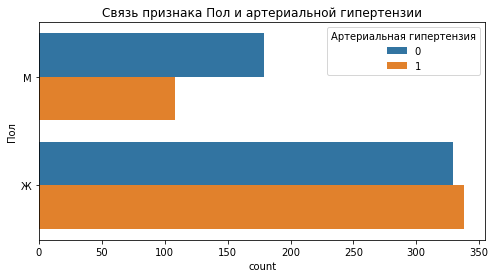

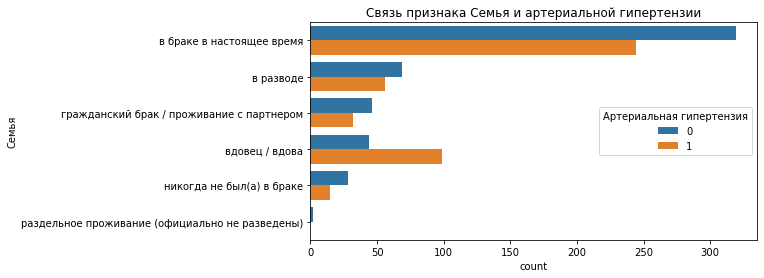

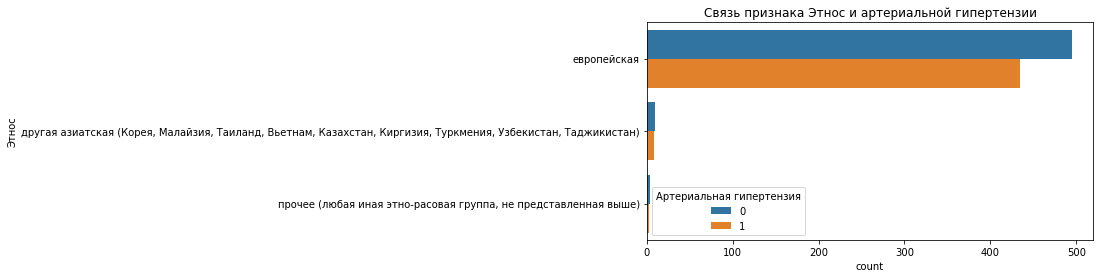

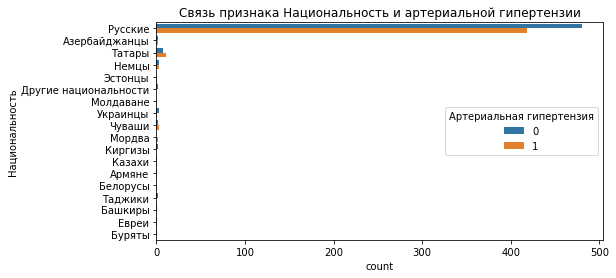

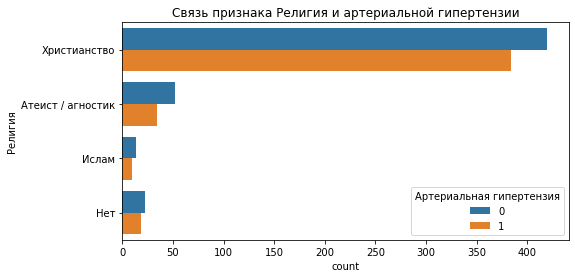

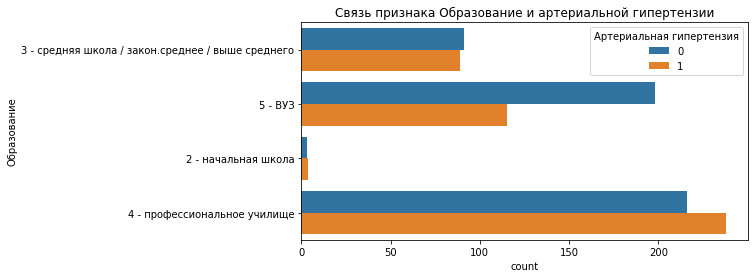

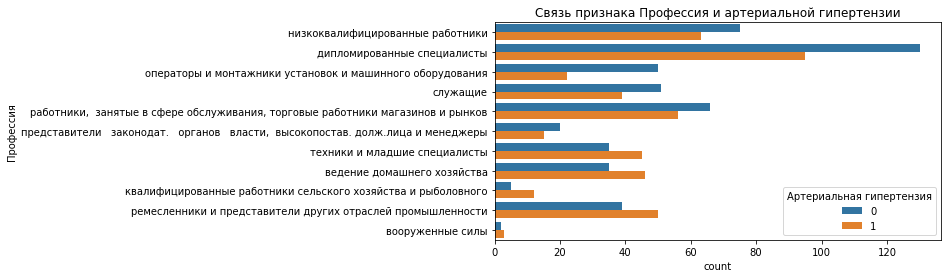

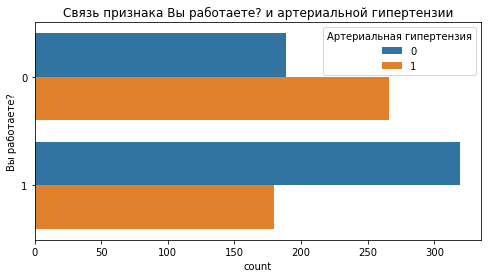

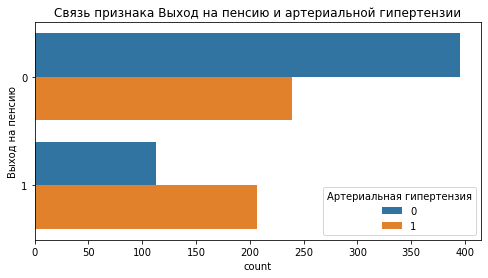

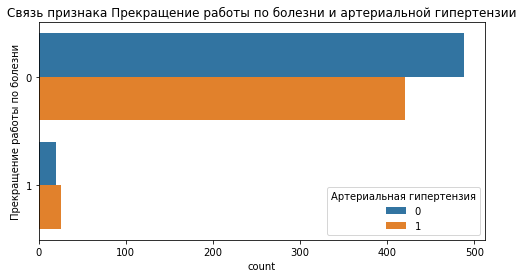

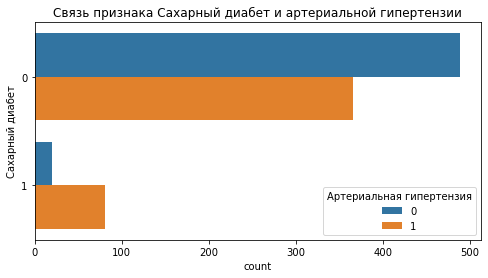

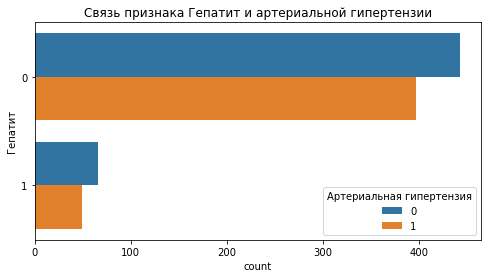

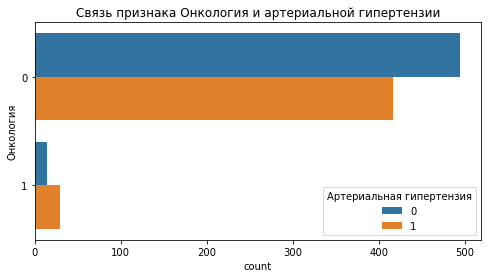

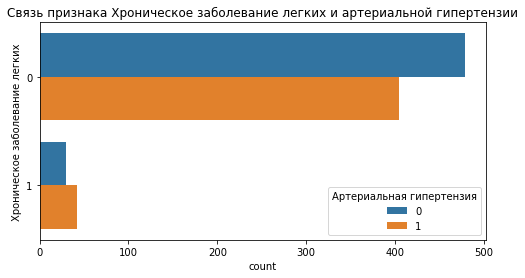

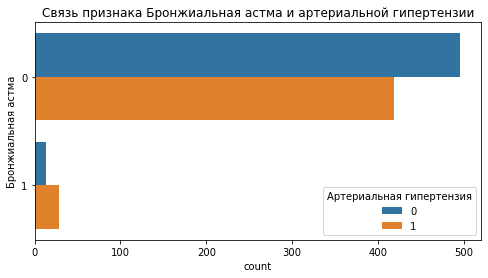

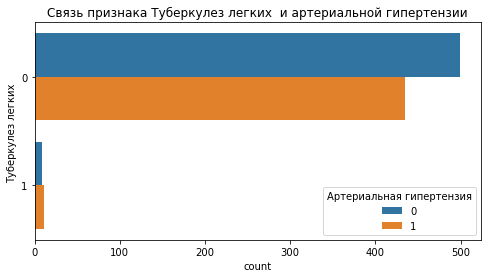

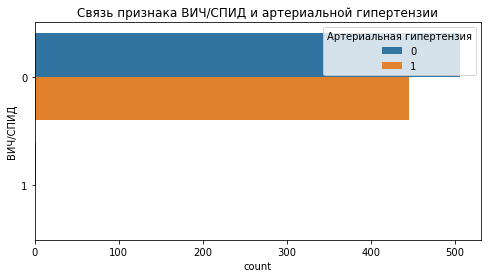

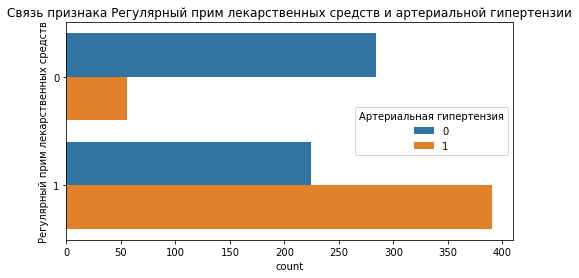

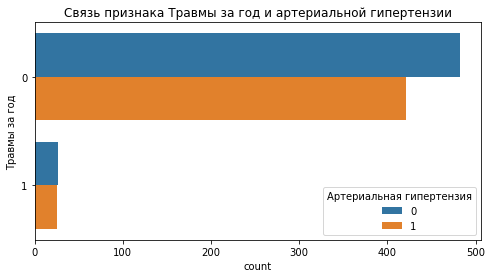

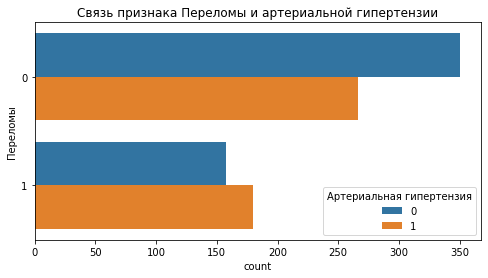

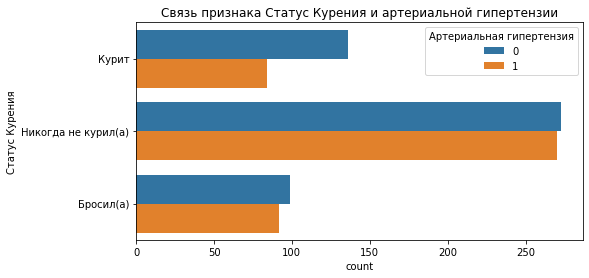

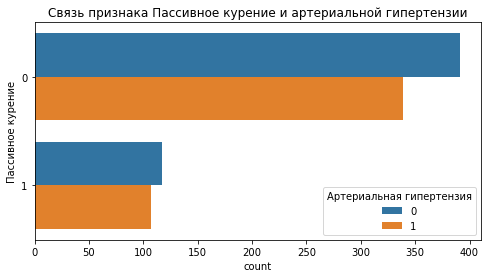

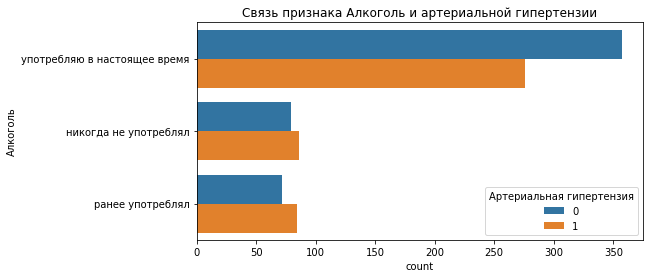

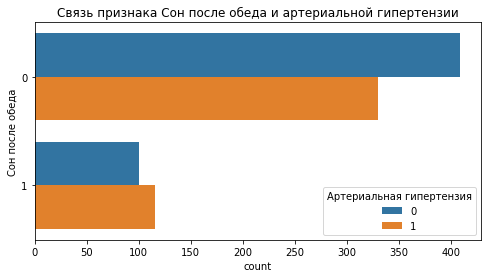

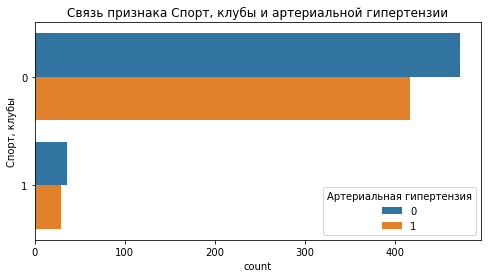

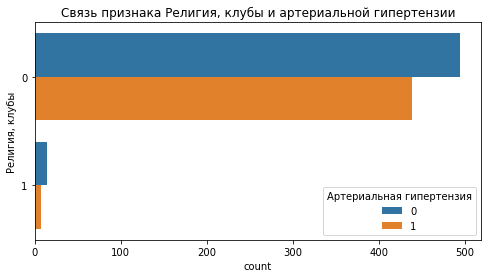

In [65]:
# закинем все имена колонок с категориальным и бинарными признаками(кроме целового)
# в один спиок

cat_names_list = ['Пол', 'Семья', 'Этнос', 'Национальность', 'Религия', 'Образование', 'Профессия', 
                 'Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 
                 'Гепатит', 'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма', 
                 'Туберкулез легких ', 'ВИЧ/СПИД', 'Регулярный прим лекарственных средств', 'Травмы за год', 
                 'Переломы', 'Статус Курения', 'Пассивное курение', 'Алкоголь', 'Сон после обеда', 'Спорт, клубы',
                 'Религия, клубы']

# построим столбчатые диаграммы связей признаков и заболевнаия
for col in cat_names_list:
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.countplot(y=col, hue='Артериальная гипертензия', data=heart)
    ax.set_title('Связь признака {} и артериальной гипертензии'.format(col))
    plt.show()

Взглянем на связь категориальных и бинарных признаков и ОНМК

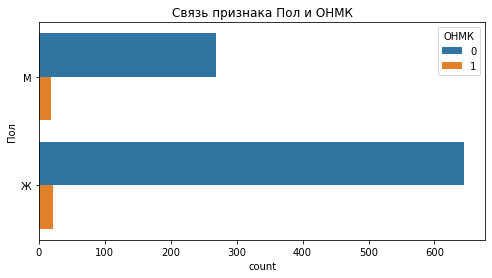

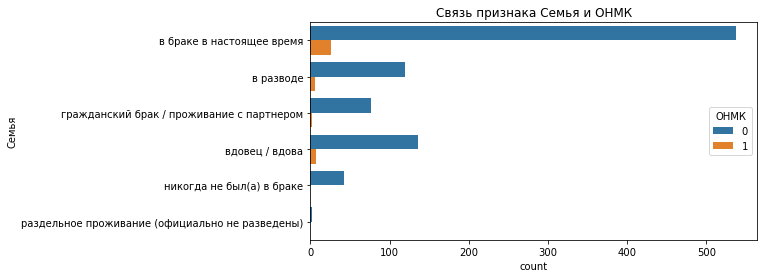

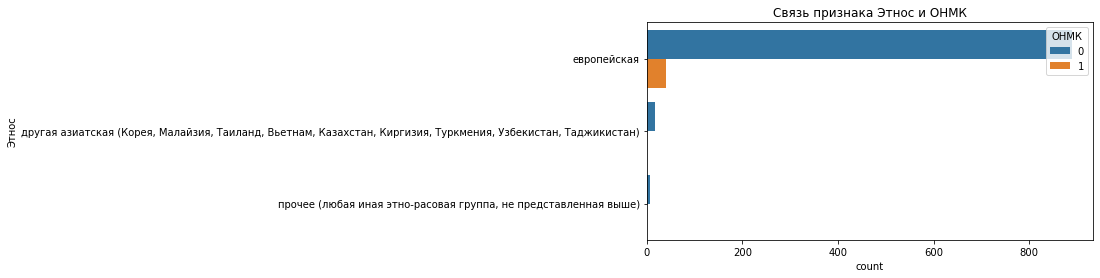

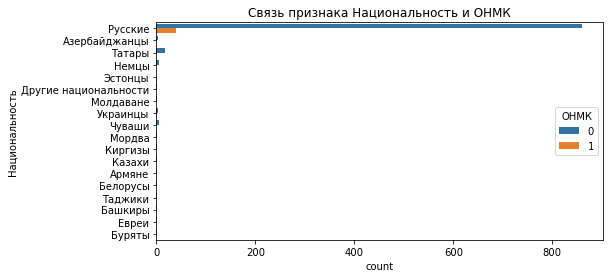

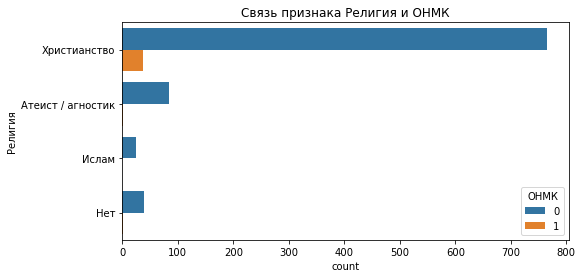

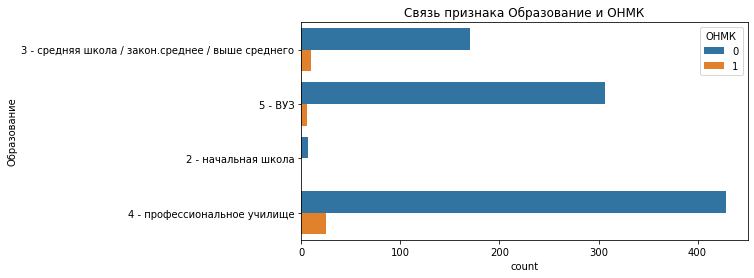

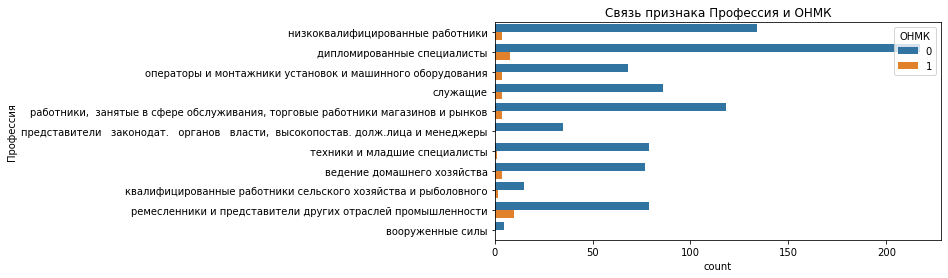

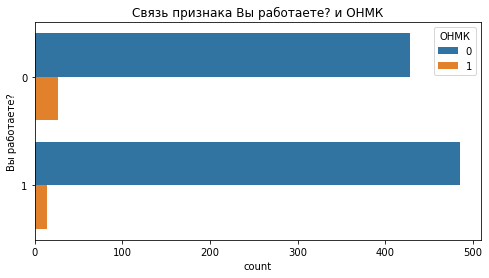

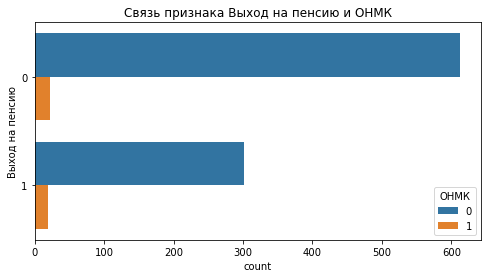

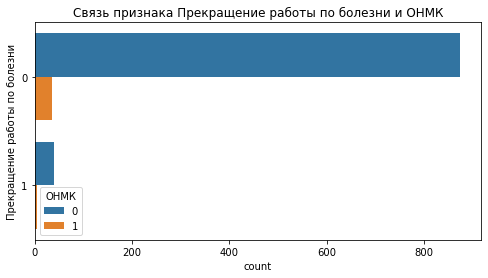

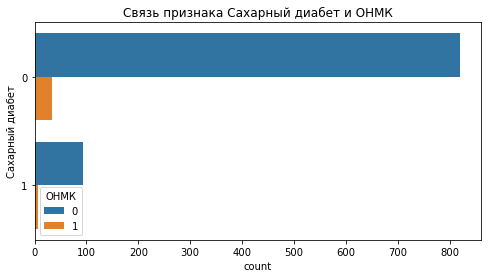

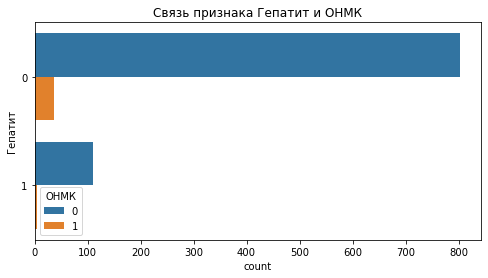

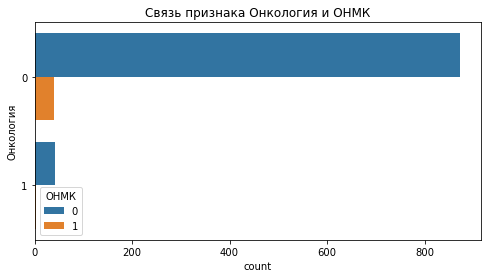

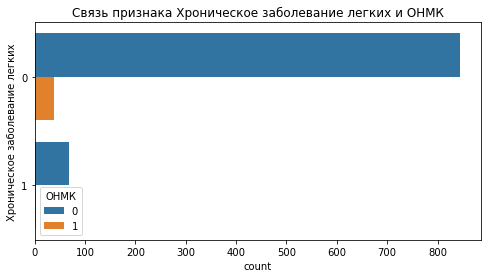

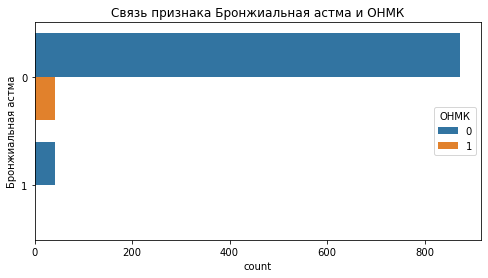

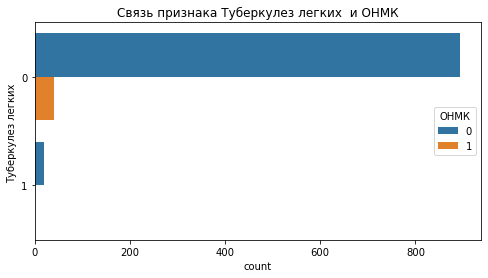

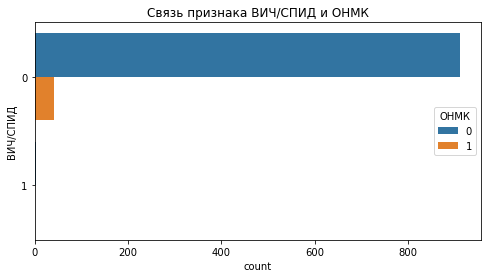

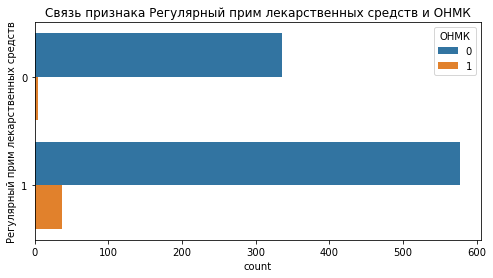

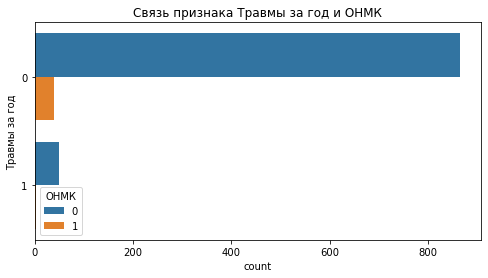

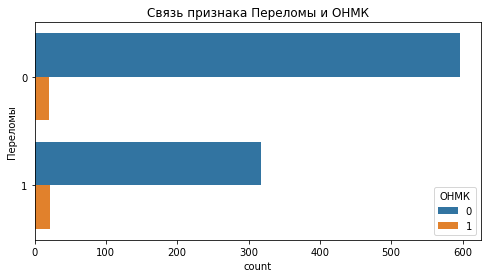

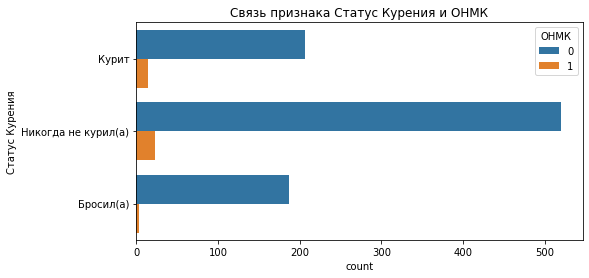

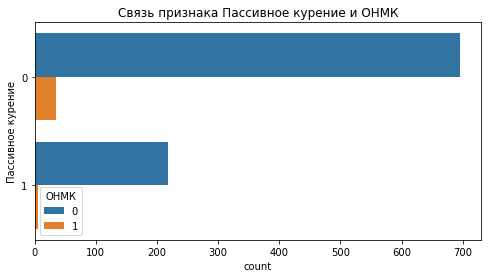

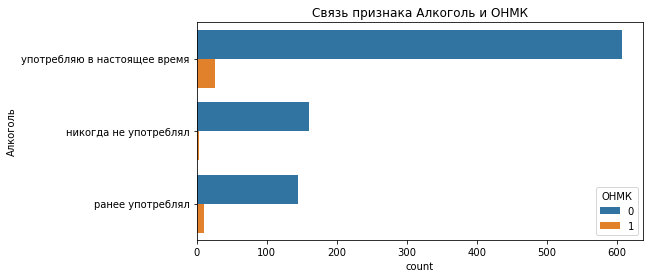

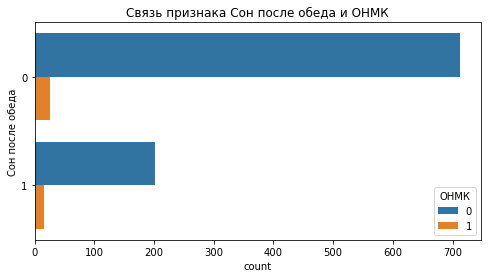

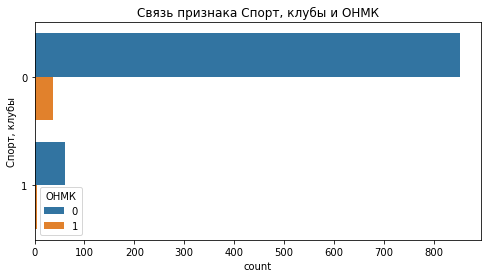

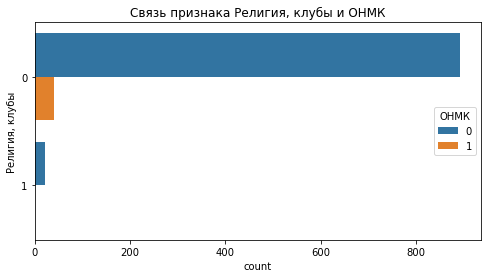

In [66]:
for col in cat_names_list:
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.countplot(y=col, hue='ОНМК', data=heart)
    ax.set_title('Связь признака {} и ОНМК'.format(col))
    plt.show()

Посмотрим также на связь со стенокардией, ИБС, инфарктом миокарда

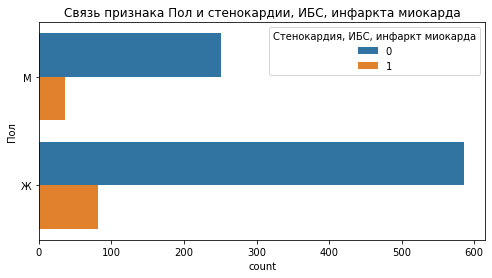

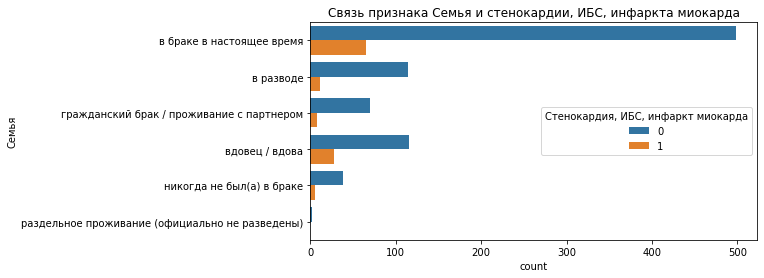

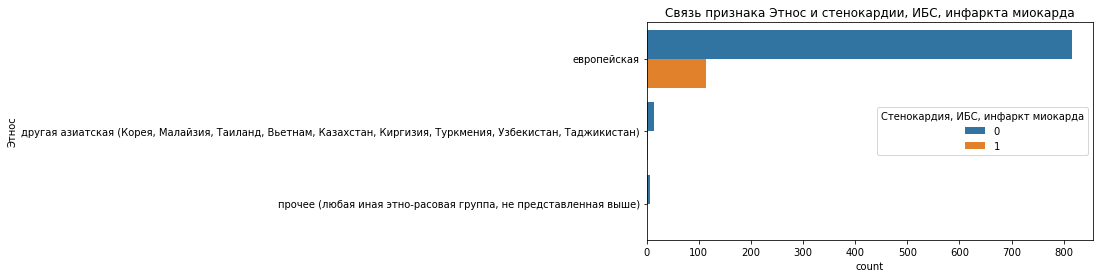

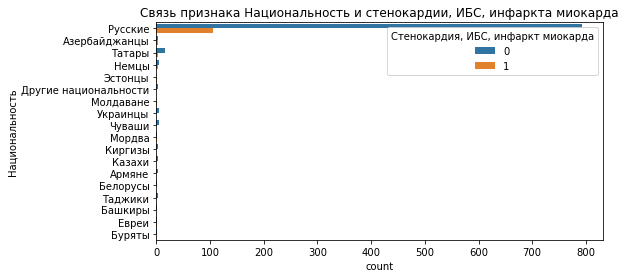

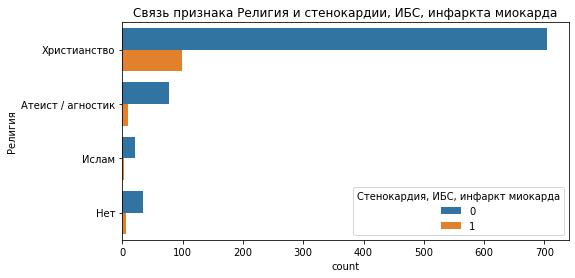

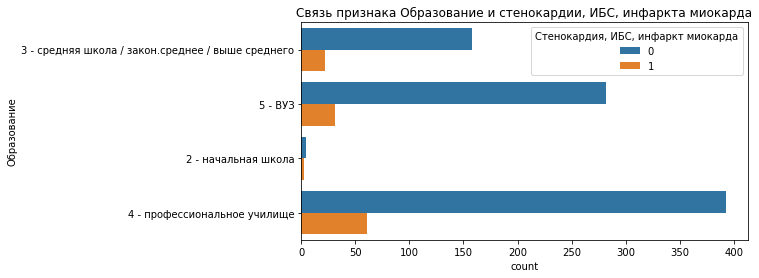

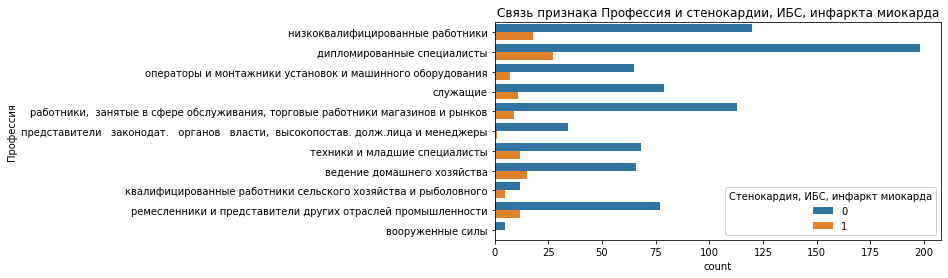

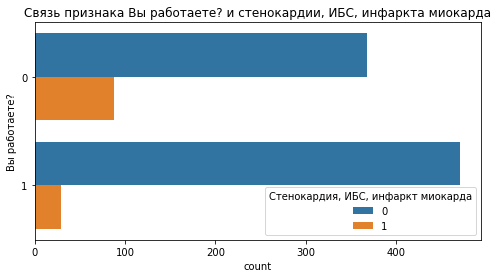

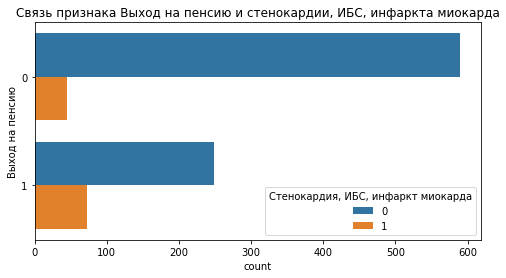

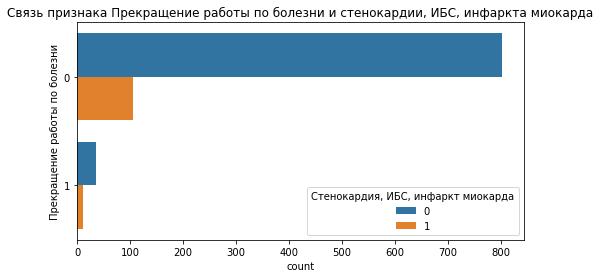

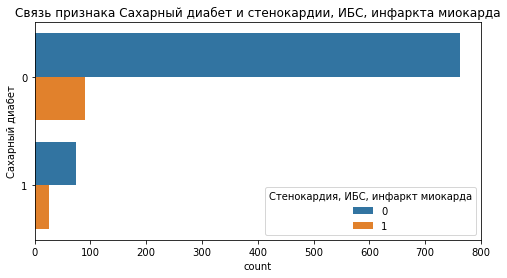

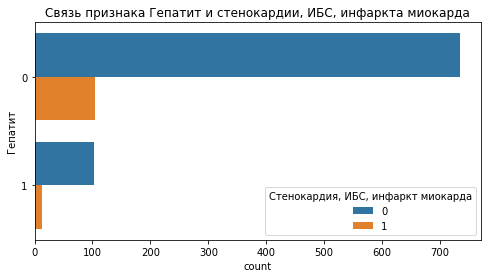

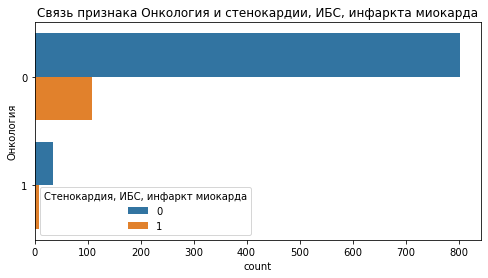

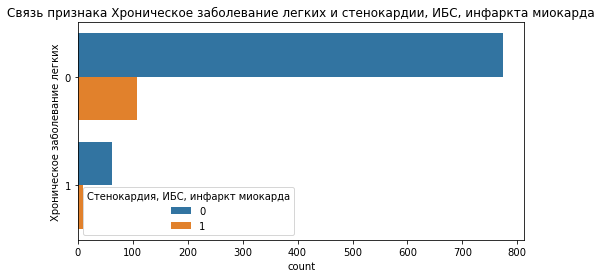

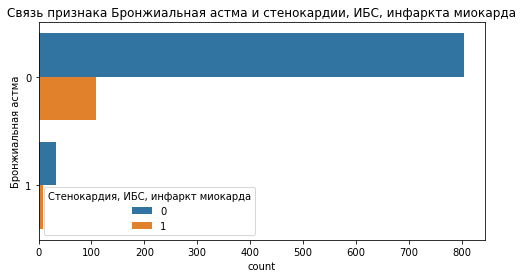

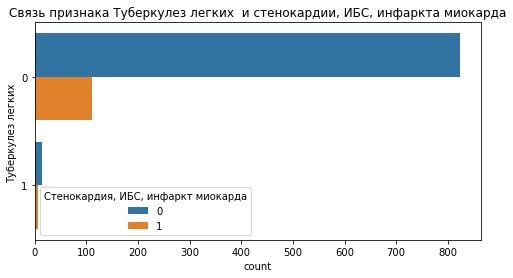

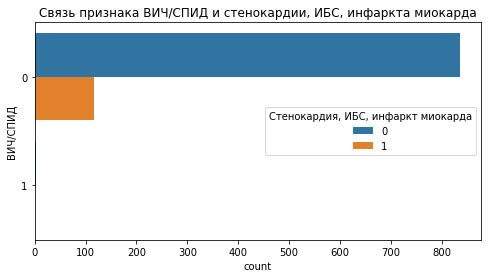

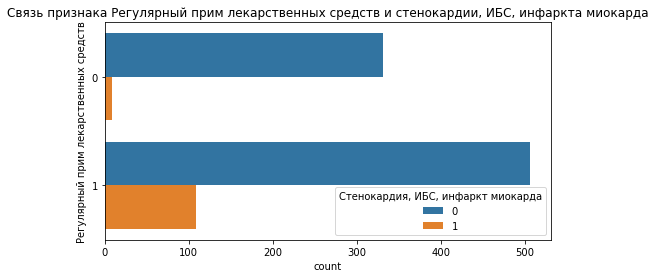

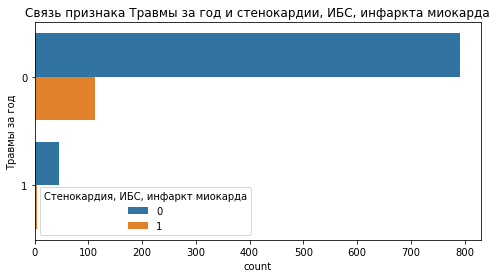

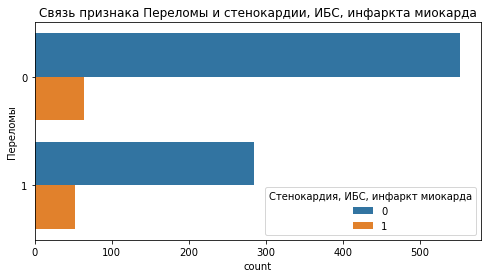

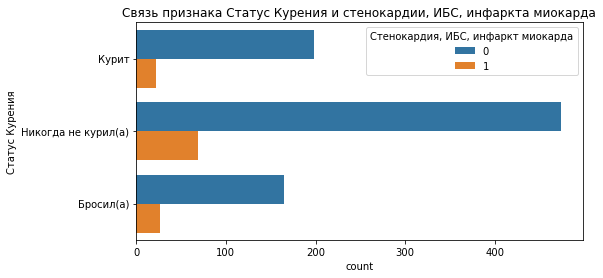

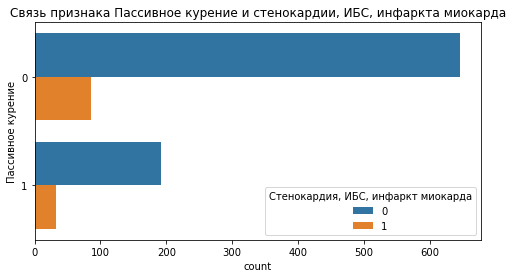

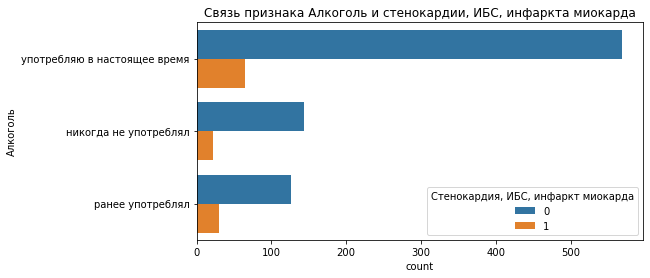

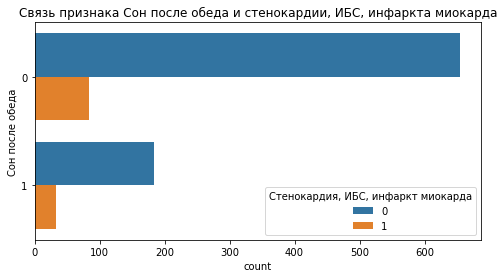

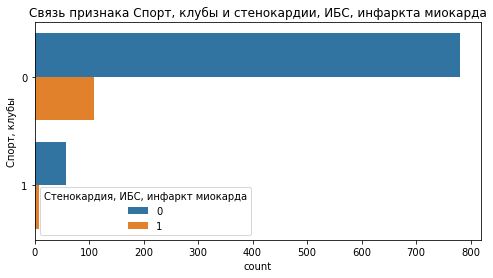

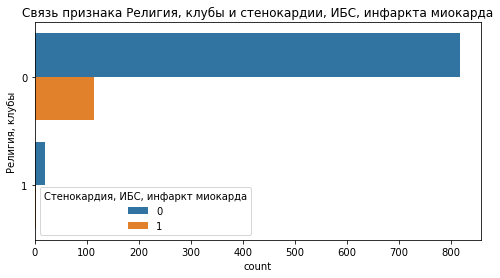

In [67]:
for col in cat_names_list:
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.countplot(y=col, hue='Стенокардия, ИБС, инфаркт миокарда', data=heart)
    ax.set_title('Связь признака {} и стенокардии, ИБС, инфаркта миокарда'.format(col))
    plt.show()

Связь категориальных/бинарных признаков и сердечной недостаточности:

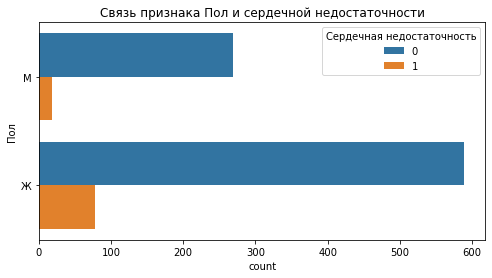

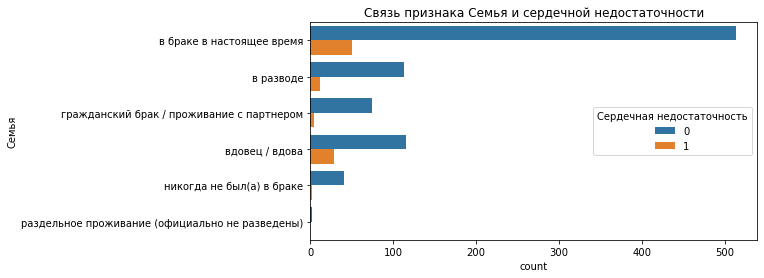

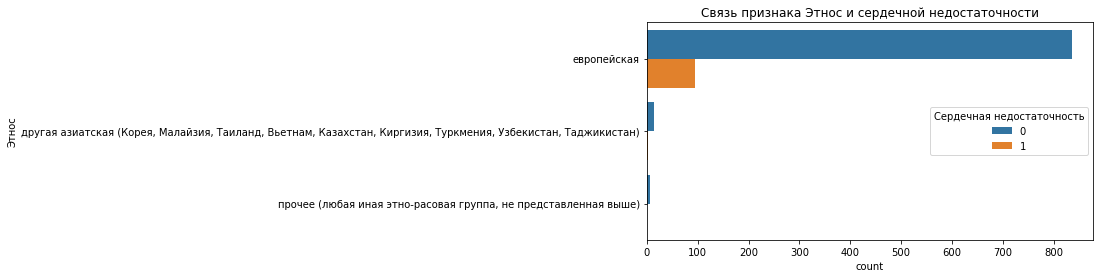

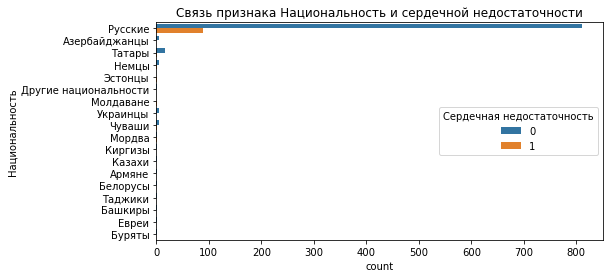

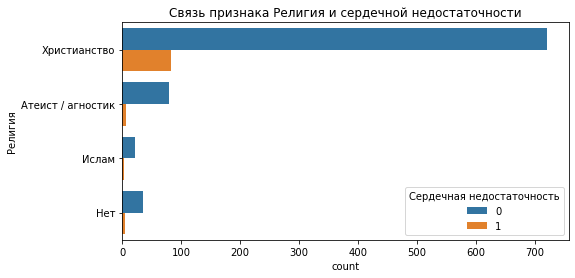

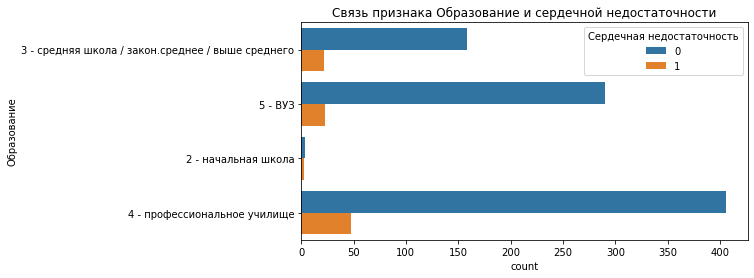

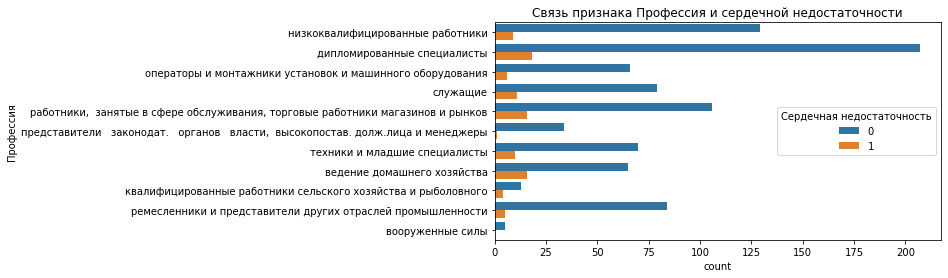

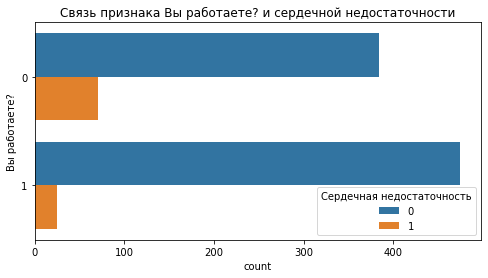

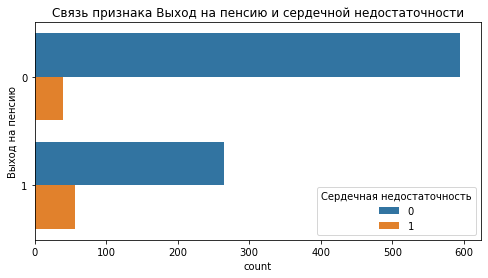

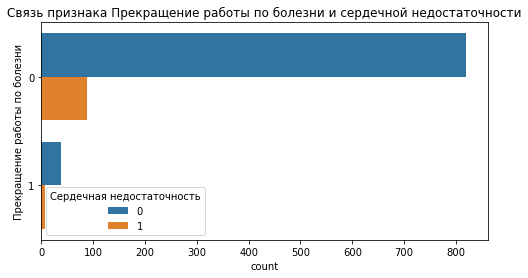

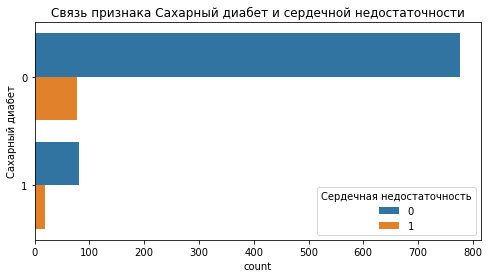

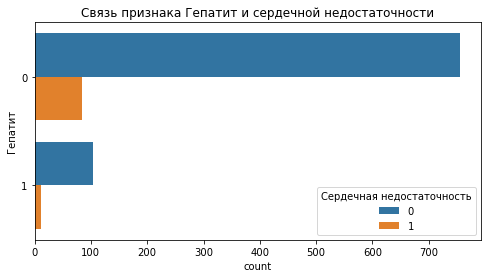

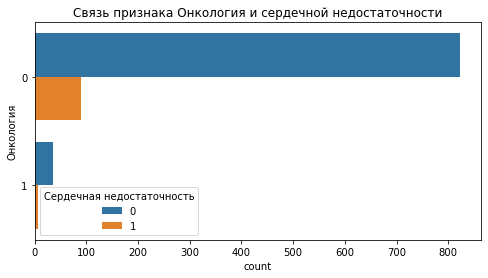

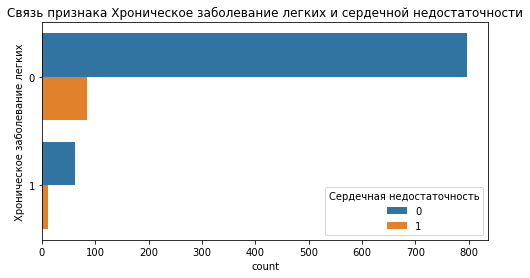

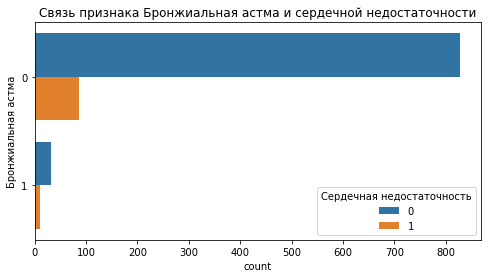

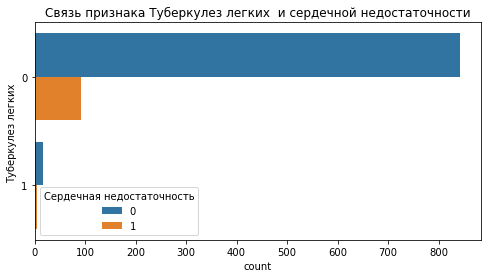

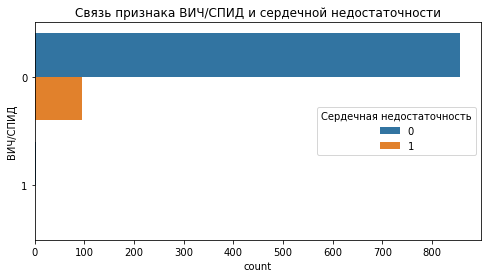

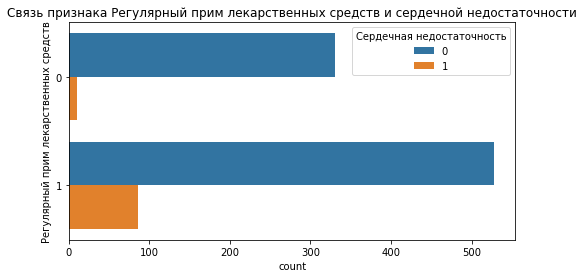

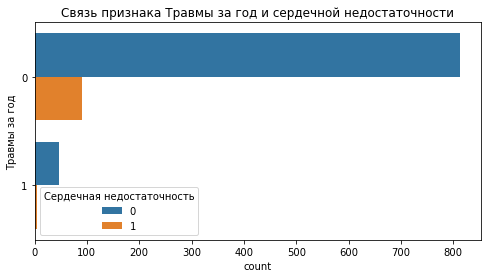

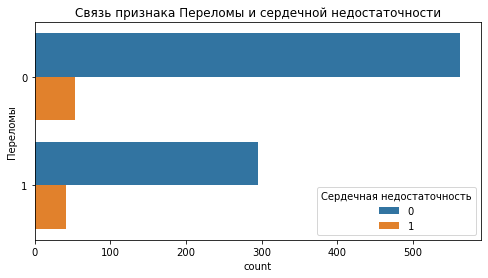

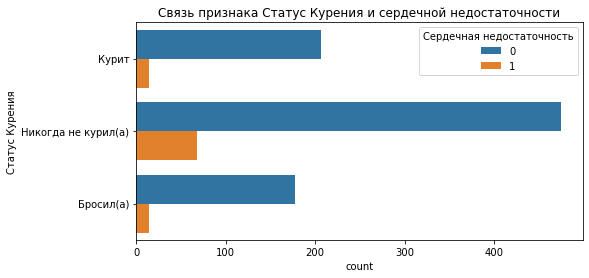

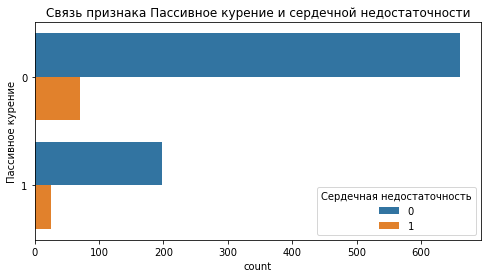

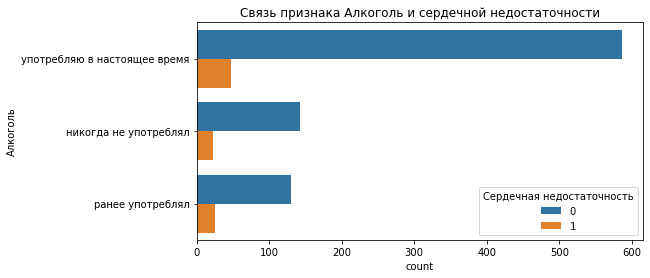

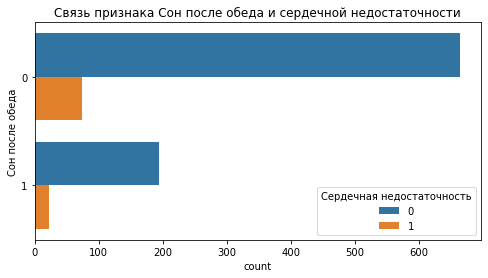

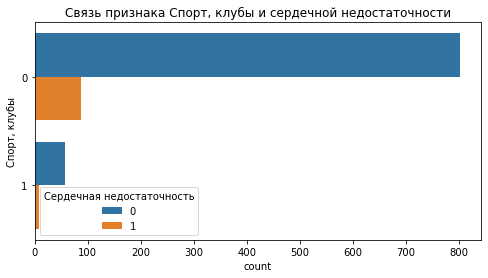

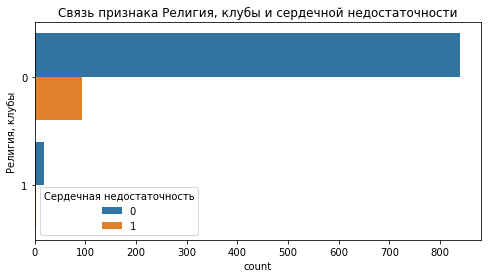

In [68]:
for col in cat_names_list:
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.countplot(y=col, hue='Сердечная недостаточность', data=heart)
    ax.set_title('Связь признака {} и сердечной недостаточности'.format(col))
    plt.show()

Взглянем на связи признаков и остальных сердечных заболеваний

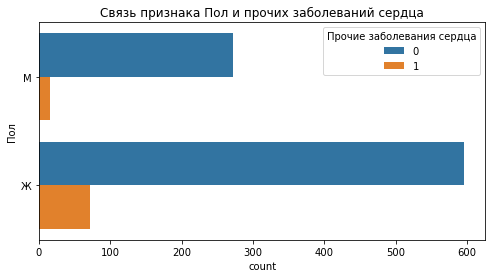

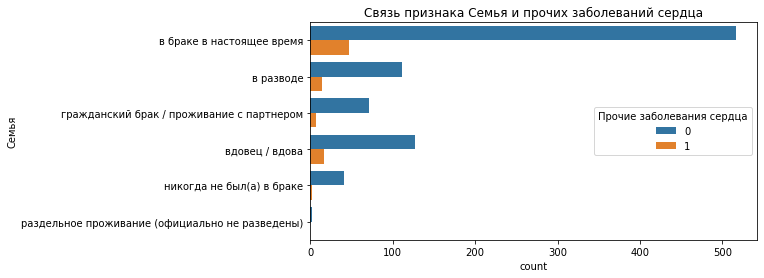

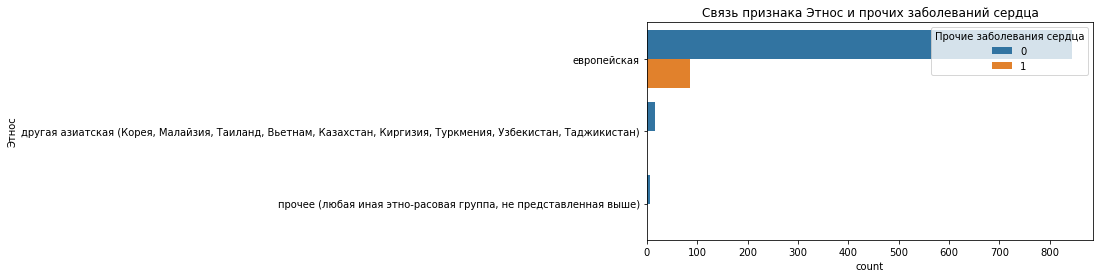

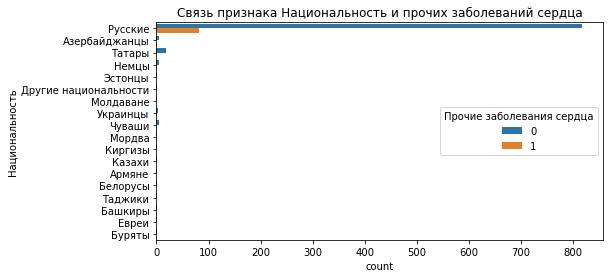

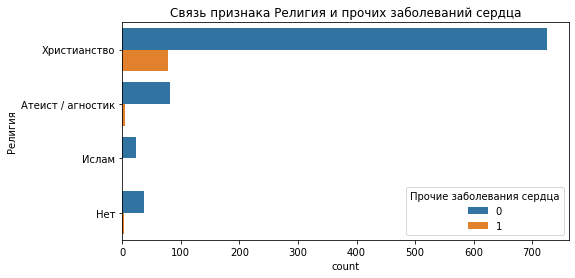

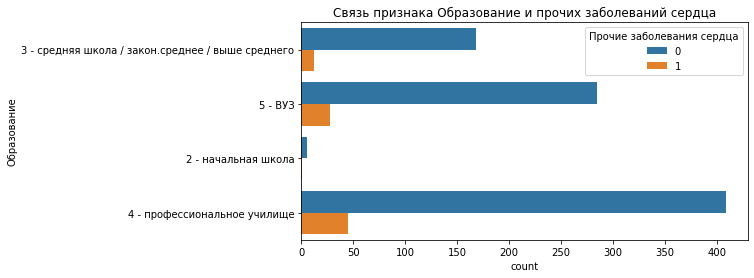

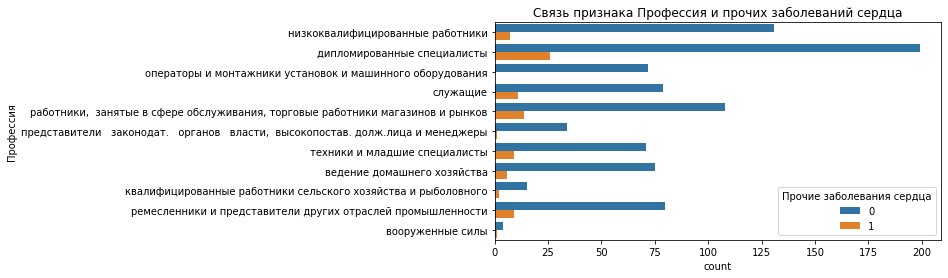

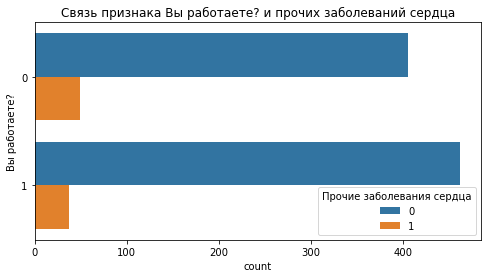

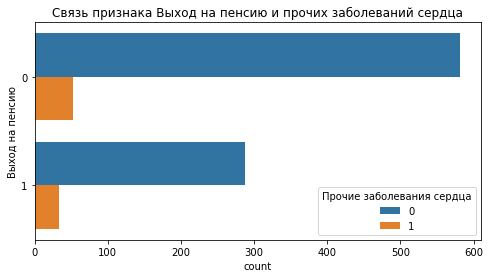

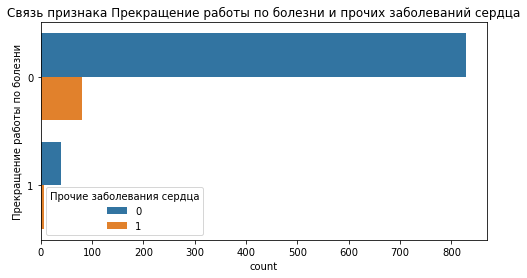

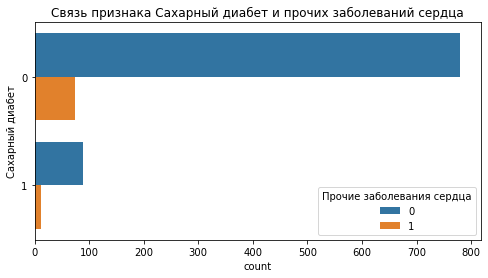

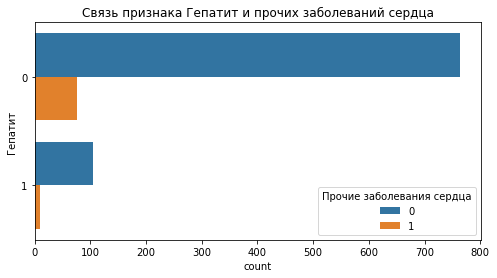

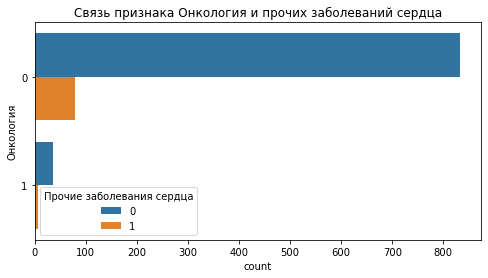

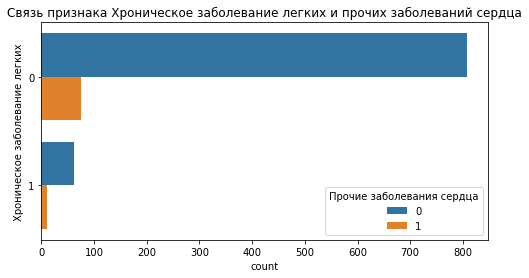

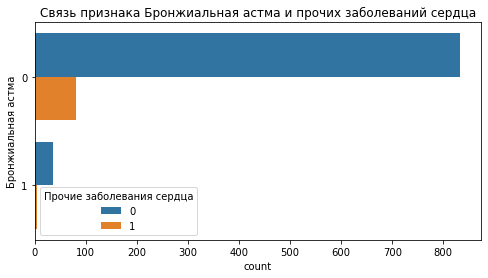

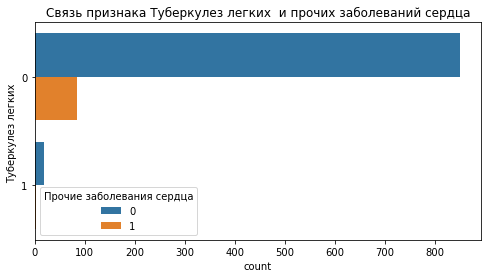

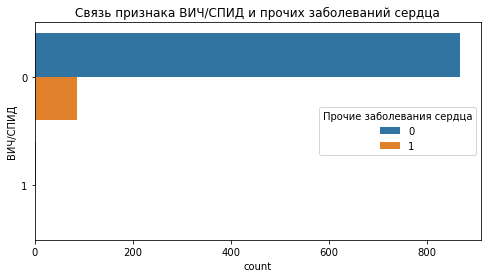

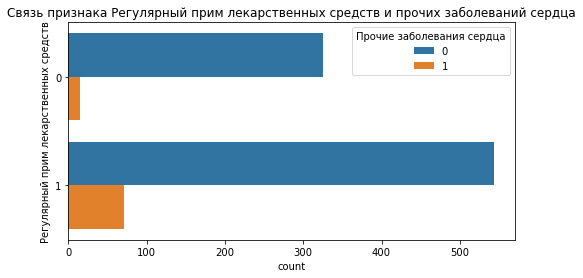

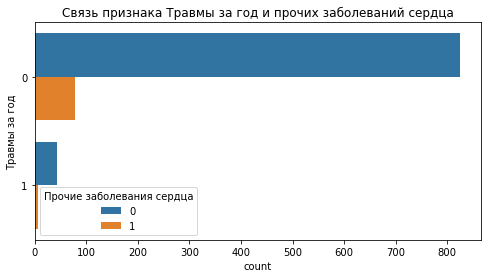

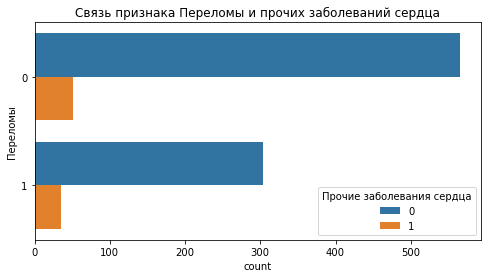

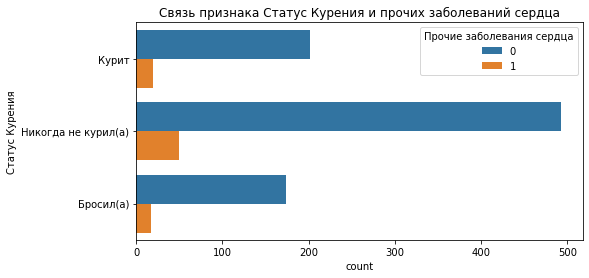

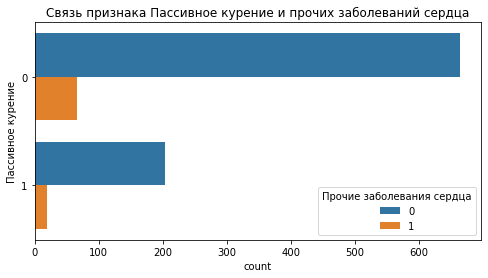

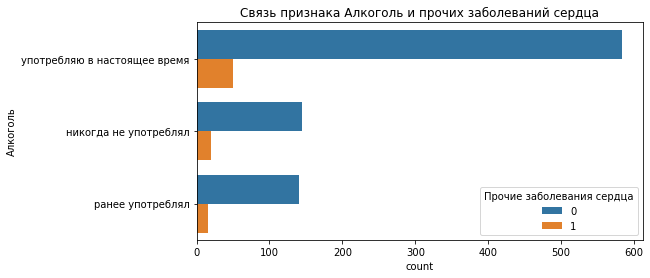

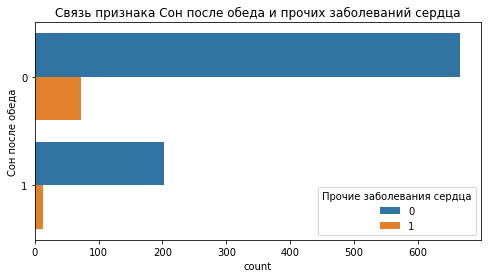

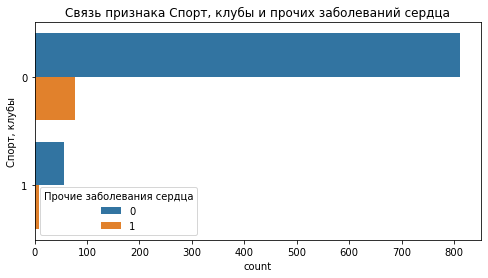

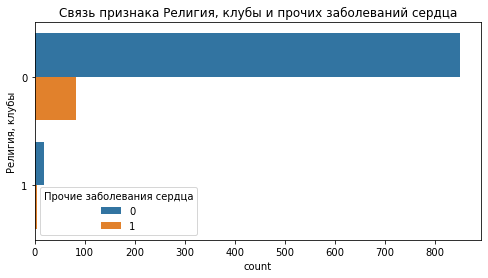

In [69]:
for col in cat_names_list:
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.countplot(y=col, hue='Прочие заболевания сердца', data=heart)
    ax.set_title('Связь признака {} и прочих заболеваний сердца'.format(col))
    plt.show()

Распределение количественных признаков в зависимости от сердечно-сосудистых заболеваний.

Посмотрим на связь между ними и артериальной гипертензией.

In [9]:
num_columns = ['Возраст курения', 'Сигарет в день', 'Возраст алког', 'Час засыпания', 'Час пробуждения', 'Длительность сна']

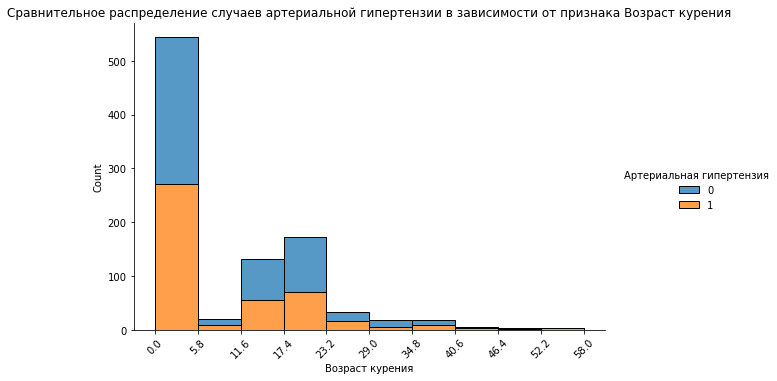

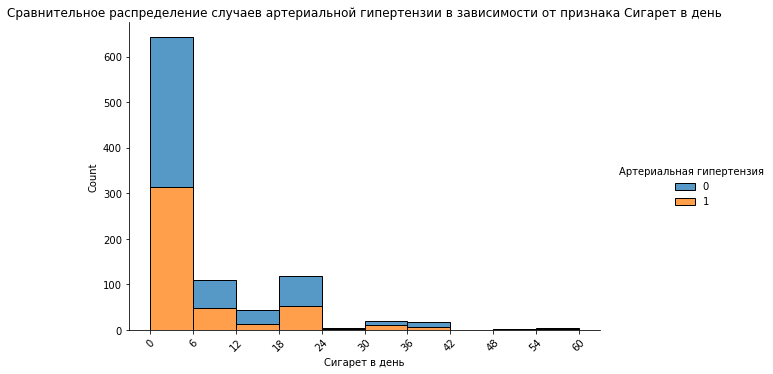

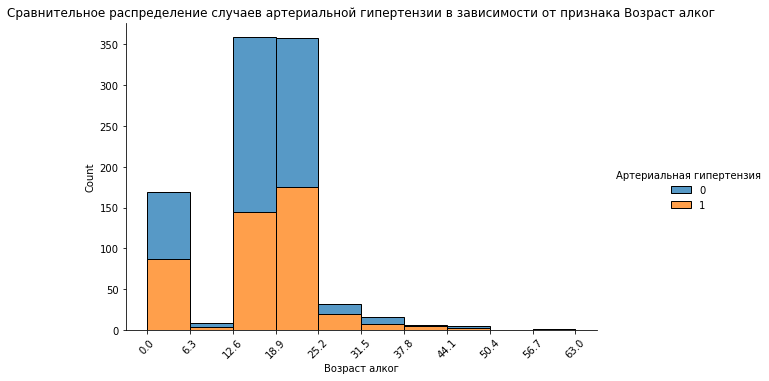

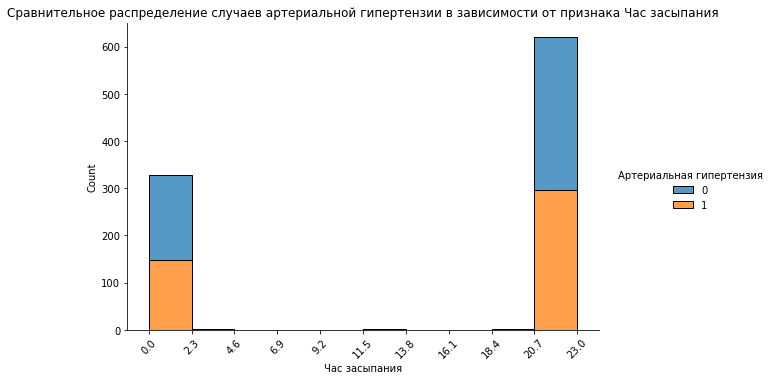

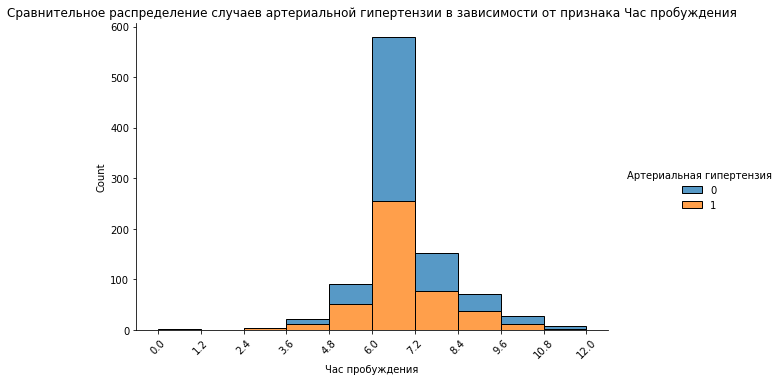

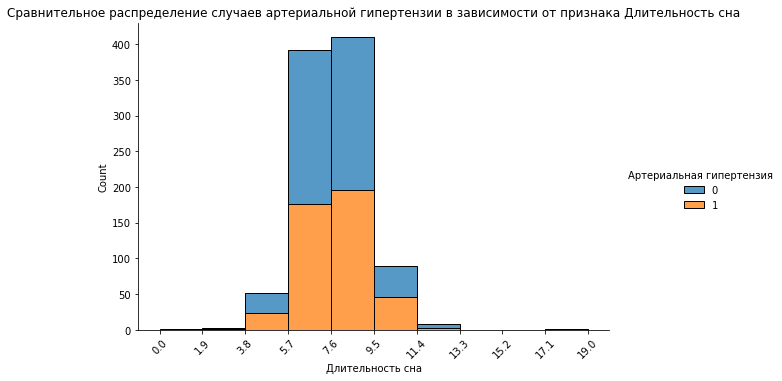

In [10]:
# подберем оптимальное кол-во стоолбцов для гистограмм
bins = int(1 + np.math.log(954, 2))

# построим гистограммы распределения
for col in num_columns:
    bin_width = heart[col].max() / bins
    x_range = [num * bin_width for num in range(bins + 1)]
    ax = sns.displot(x=col, hue='Артериальная гипертензия', data=heart, aspect=1.5, bins=bins, multiple='stack')
    plt.xticks(x_range, rotation=45)
    plt.title('Сравнительное распределение случаев артериальной гипертензии в зависимости от признака {}'.format(col))

Связь кол-венных признаков и ОНМК:

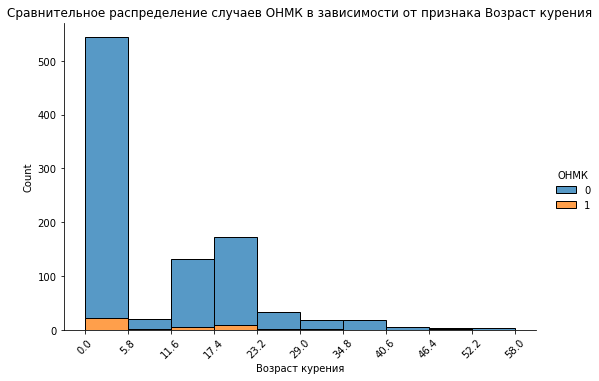

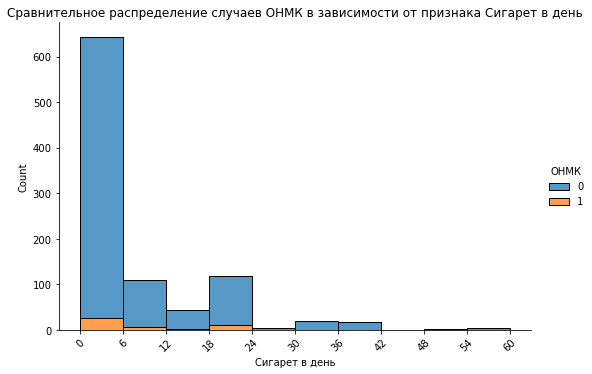

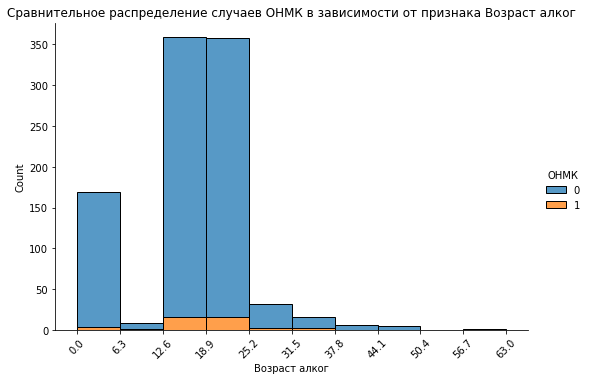

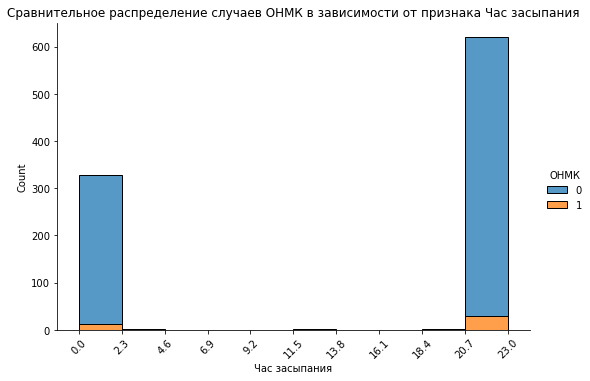

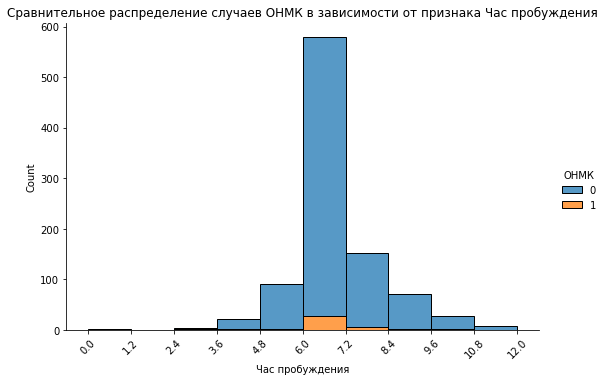

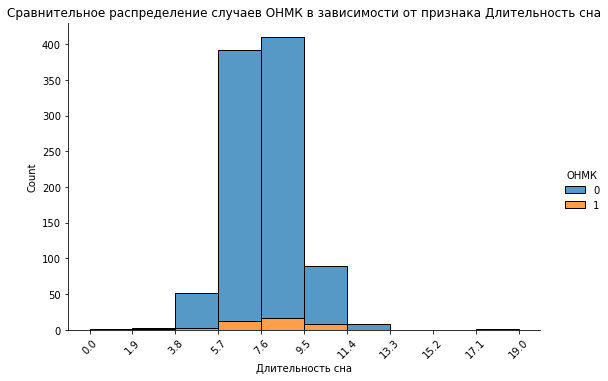

In [11]:
bins = int(1 + np.math.log(954, 2))

for col in num_columns:
    bin_width = heart[col].max() / bins
    x_range = [num * bin_width for num in range(bins + 1)]
    ax = sns.displot(x=col, hue='ОНМК', data=heart, aspect=1.5, bins=bins, multiple='stack')
    plt.xticks(x_range, rotation=45)
    plt.title('Сравнительное распределение случаев ОНМК в зависимости от признака {}'.format(col))

Гистограммы сравнительного распределения случаев стенокардии, ИБС, инфаркта миокарда в зависимости от кол-венных признаков:

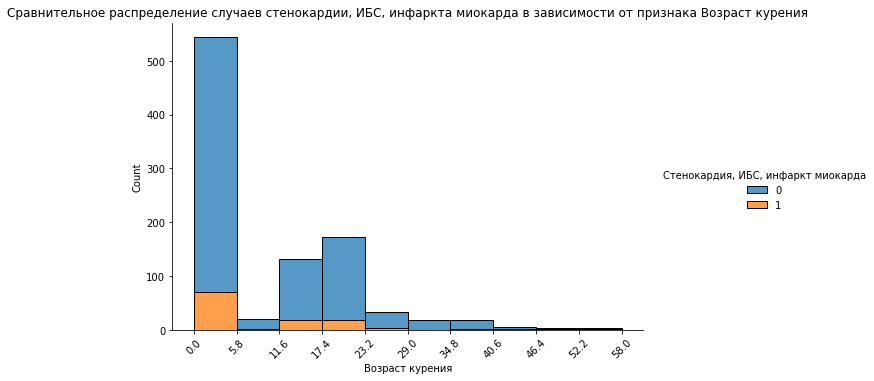

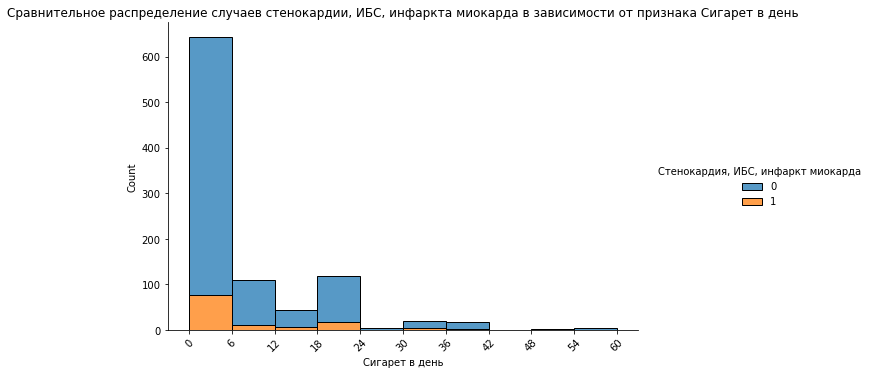

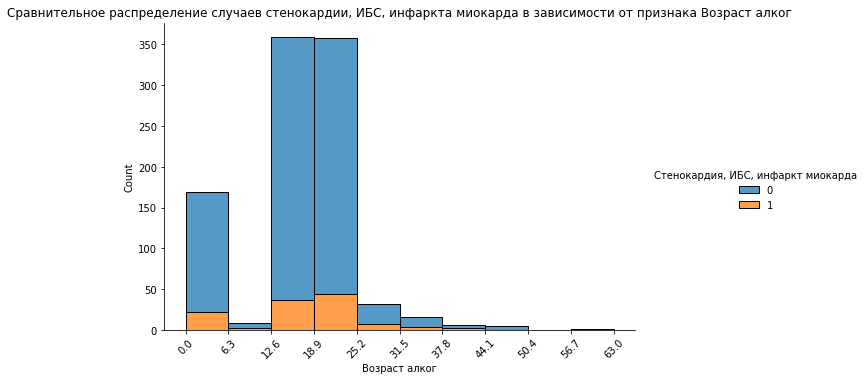

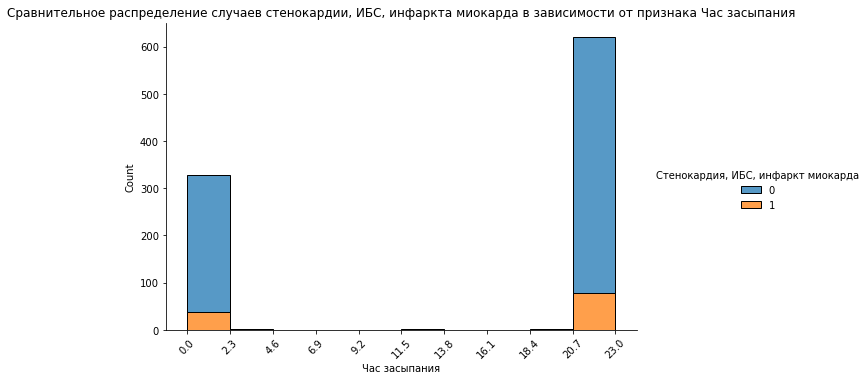

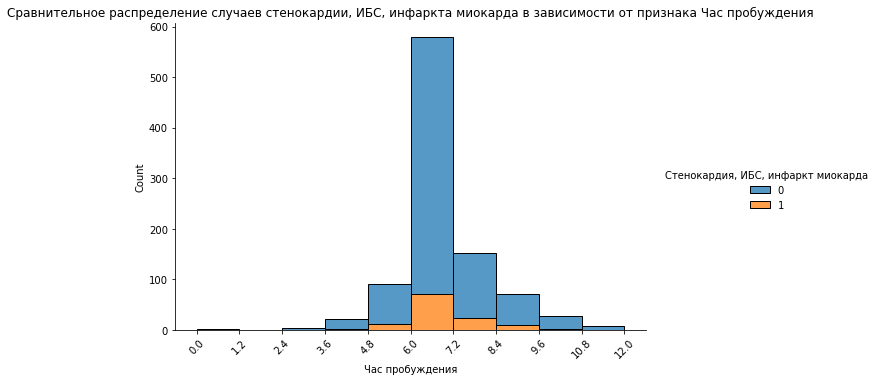

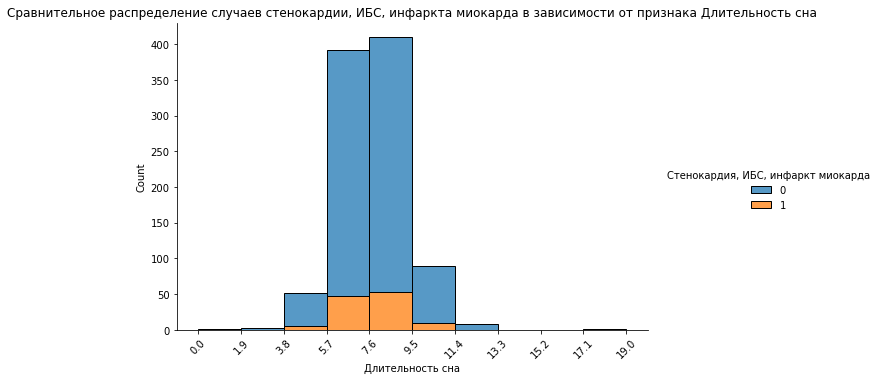

In [12]:
bins = int(1 + np.math.log(954, 2))

for col in num_columns:
    bin_width = heart[col].max() / bins
    x_range = [num * bin_width for num in range(bins + 1)]
    ax = sns.displot(x=col, hue='Стенокардия, ИБС, инфаркт миокарда', data=heart, aspect=1.5, bins=bins, multiple='stack')
    plt.xticks(x_range, rotation=45)
    plt.title('Сравнительное распределение случаев стенокардии, ИБС, инфаркта миокарда в зависимости от признака {}'.
              format(col))

Связь случаев сердечной недостаточности и кол-венных признаков:

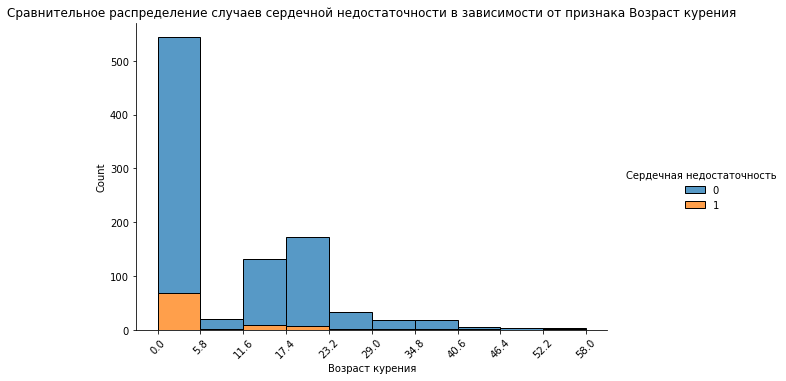

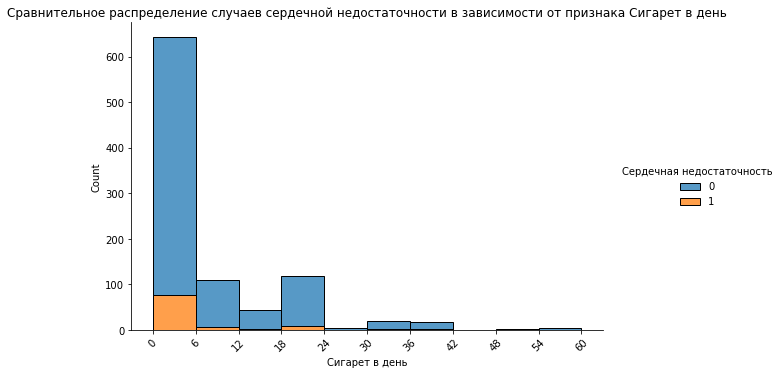

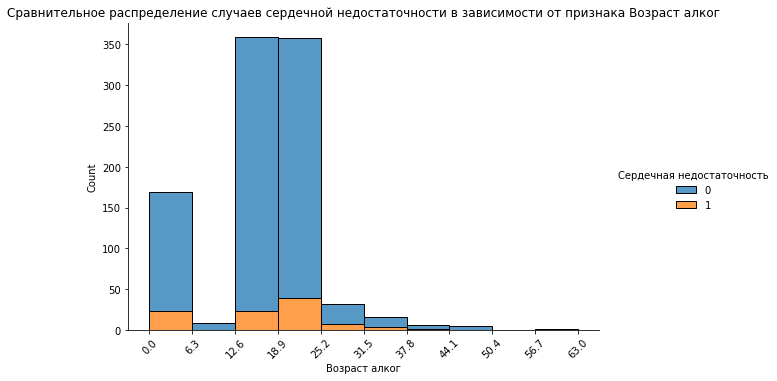

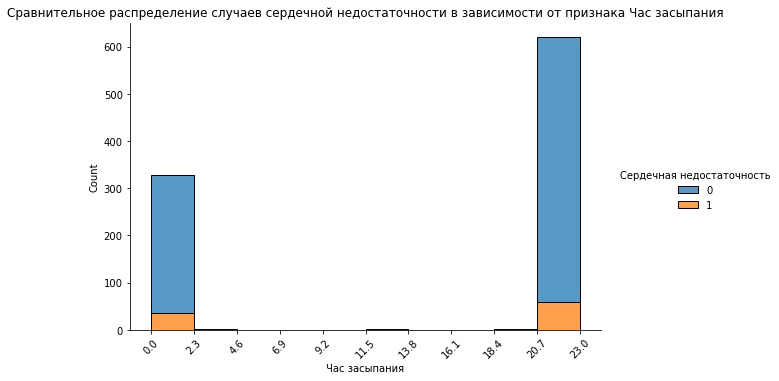

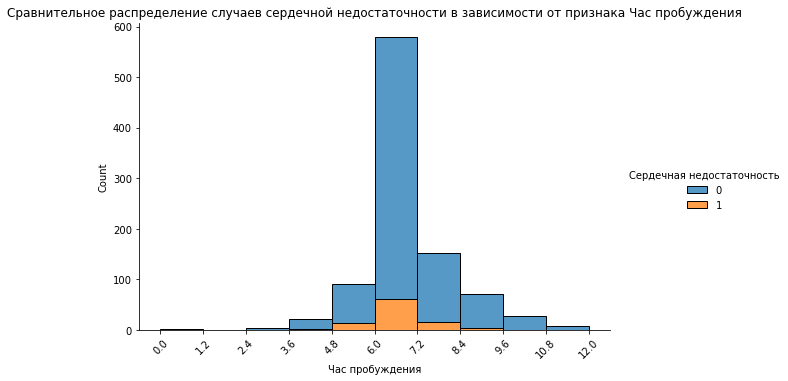

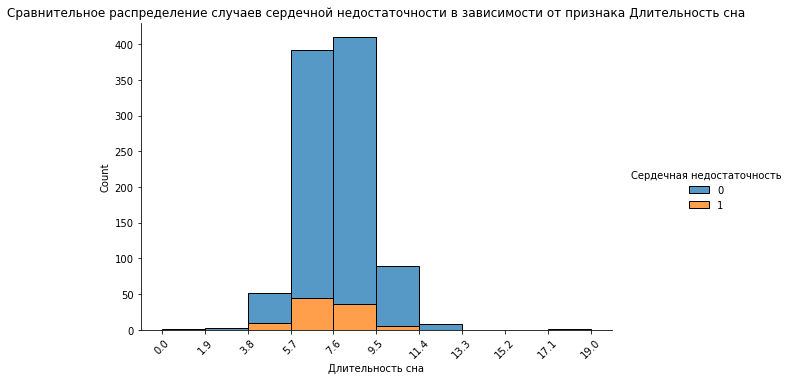

In [13]:
for col in num_columns:
    bin_width = heart[col].max() / bins
    x_range = [num * bin_width for num in range(bins + 1)]
    ax = sns.displot(x=col, hue='Сердечная недостаточность', data=heart, aspect=1.5, bins=bins, multiple='stack')
    plt.xticks(x_range, rotation=45)
    plt.title('Сравнительное распределение случаев сердечной недостаточности в зависимости от признака {}'.
              format(col))

Гистограммы распределения случаев прочих заболеваний сердца в зависимости от кол-венных признаков:

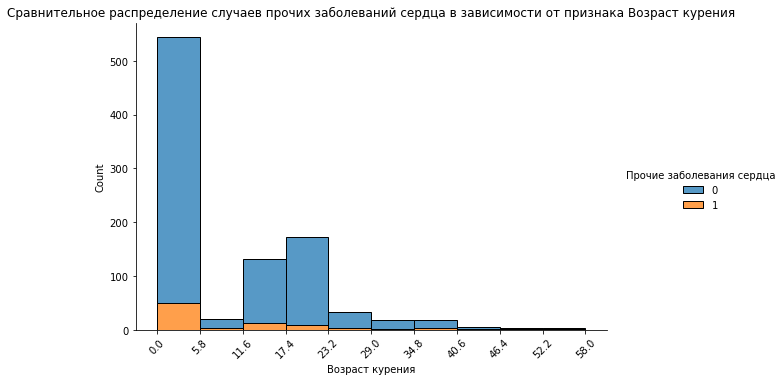

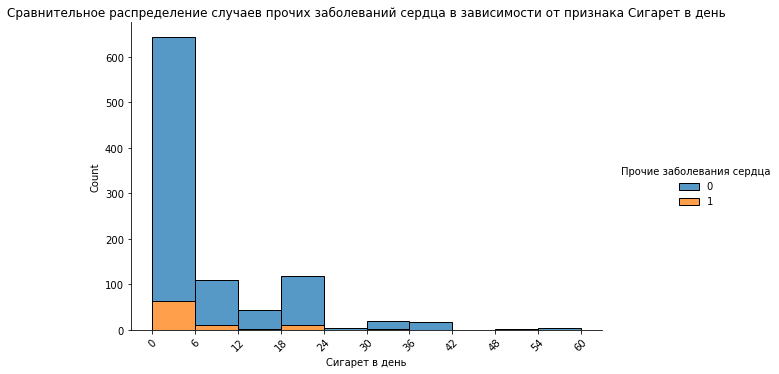

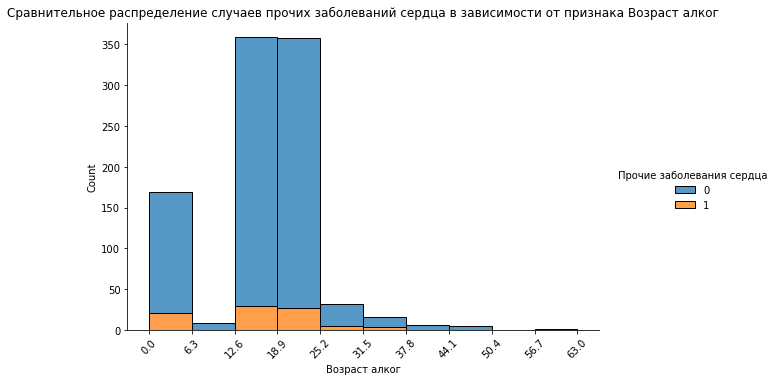

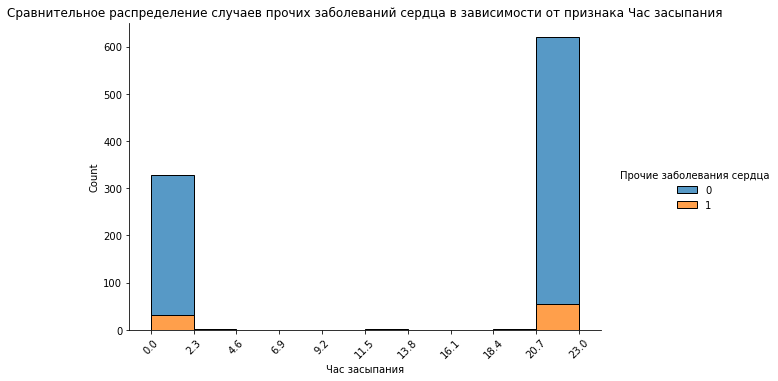

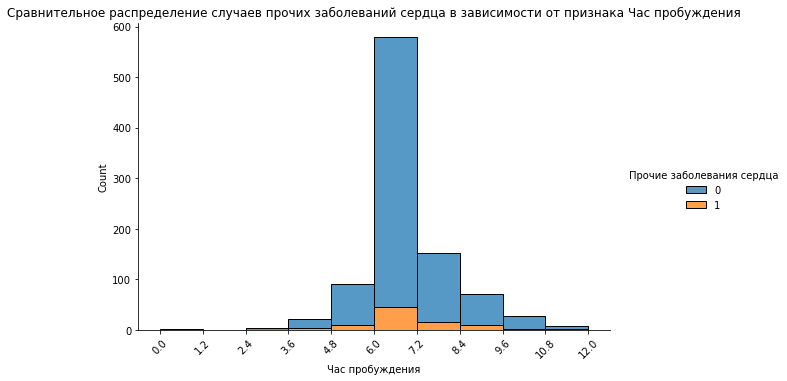

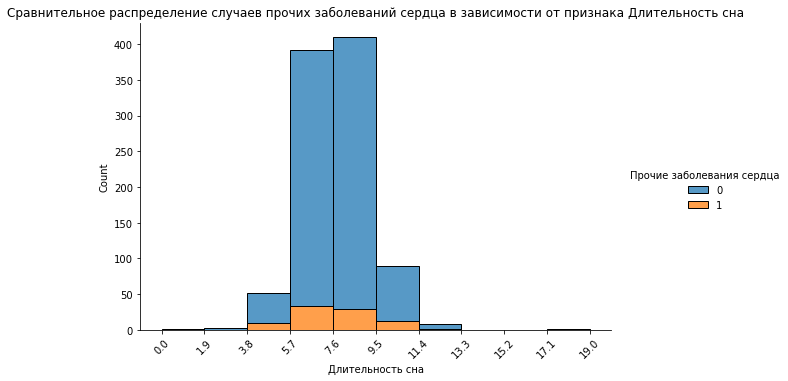

In [14]:
for col in num_columns:
    bin_width = heart[col].max() / bins
    x_range = [num * bin_width for num in range(bins + 1)]
    ax = sns.displot(x=col, hue='Прочие заболевания сердца', data=heart, aspect=1.5, bins=bins, multiple='stack')
    plt.xticks(x_range, rotation=45)
    plt.title('Сравнительное распределение случаев прочих заболеваний сердца в зависимости от признака {}'.
              format(col))

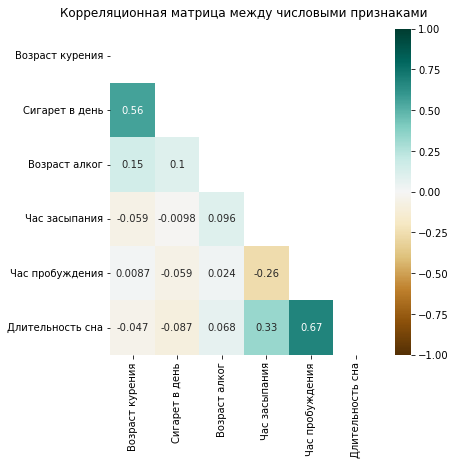

In [15]:
# Воспользуемся тепловой картой корреляции, чтобы лучше увидеть связь между количествнными признаками

df_corr = heart[num_columns].corr()
mask_matrix = np.zeros_like(df_corr)
mask_matrix[np.triu_indices_from(mask_matrix)] = True
plt.figure(figsize=(6, 6))  

sns.heatmap(df_corr, cmap='BrBG',annot=True, vmin=-1, vmax=1, center=0, 
            annot_kws={"fontsize":10}, linecolor='black', mask=mask_matrix
           ) 

plt.title('Корреляционная матрица между числовыми признаками', fontsize=12, pad=12 )
plt.show()

Наконец, желательно увидеть всю картину целиком. Для лучшего понимания зависимостей между признаками воспользуемся 
методом Phik(𝜙k), который реализуется благодаря библиотеке phik, появившейся в конце 2018 г. Ее создатели уверяют нас 
в том, что "Phik(𝜙k) - новый практичный коэффициент корреляции, который последовательно работает между категориальными, 
порядковыми и интервальными переменными, фиксирует нелинейную зависимость и возвращается к коэффициенту корреляции 
Пирсона в случае двумерного нормального входного распределения".

In [55]:
# Удалим ненужные столбцы
heart = heart.drop(['index', 'ID', 'ВИЧ/СПИД', 'ID_y','Время засыпания', 'Время пробуждения'], axis=1)

interval columns not set, guessing: ['Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит', 'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы', 'Возраст курения', 'Сигарет в день', 'Пассивное курение', 'Возраст алког', 'Сон после обеда', 'Спорт, клубы', 'Религия, клубы', 'Час засыпания', 'Час пробуждения', 'Длительность сна', 'Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']


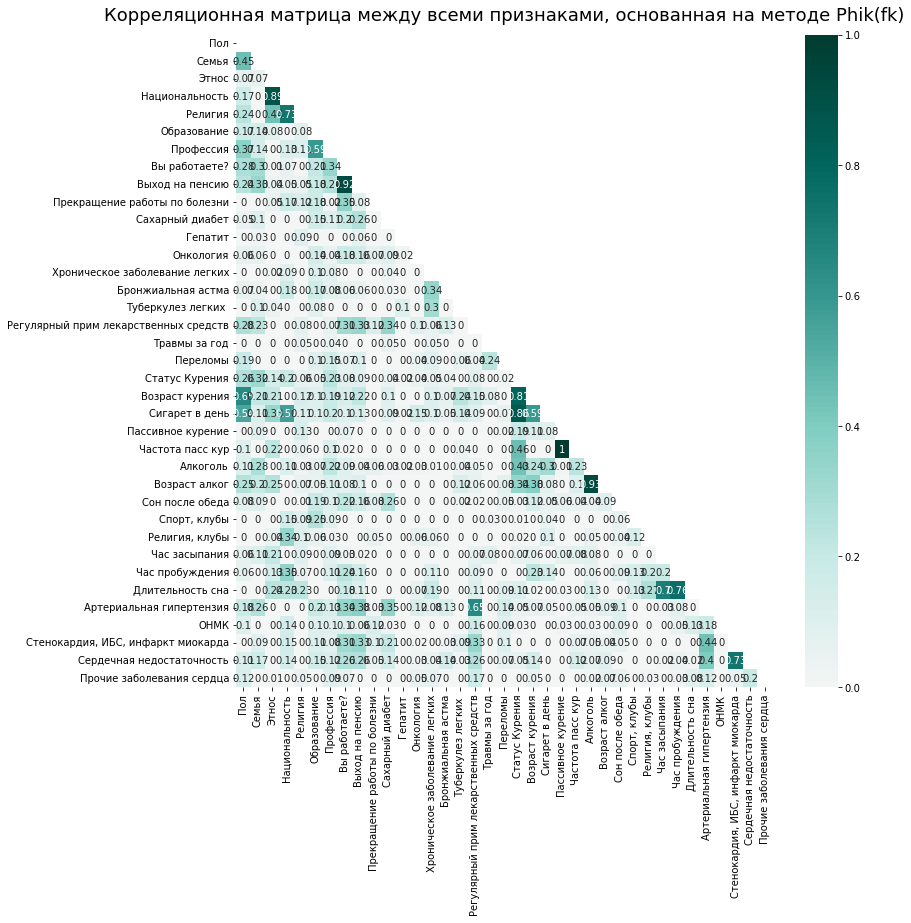

In [44]:
# постороим phik-матрицy c помощью библиотеки phik
phik_matrix = heart.phik_matrix()
#phik_matrix = df_users.phik_matrix(interval_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])
phik_matrix = np.round(phik_matrix, 2)

# построим треугольную тепловую карту корреляции, помня о том, что матрица возвращает значения между 0 и 1
mask_matrix = np.zeros_like(phik_matrix)
mask_matrix[np.triu_indices_from(mask_matrix)] = True
plt.figure(figsize=(12, 12)) 
sns.heatmap(phik_matrix, cmap='BrBG',annot=True, vmin=0, vmax=1, center=0, 
            annot_kws={"fontsize":10}, linecolor='black', mask=mask_matrix
           ) 
plt.title('Корреляционная матрица между всеми признаками, основанная на методе Phik(fk)', fontsize=18, pad=14)
plt.show()

In [45]:
# Так как на тепловой карте плохо видны коэффициенты корреляции, посмотрим на них на таблице 

phik_matrix = heart.phik_matrix()
phik_matrix 

interval columns not set, guessing: ['Вы работаете?', 'Выход на пенсию', 'Прекращение работы по болезни', 'Сахарный диабет', 'Гепатит', 'Онкология', 'Хроническое заболевание легких', 'Бронжиальная астма', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 'Травмы за год', 'Переломы', 'Возраст курения', 'Сигарет в день', 'Пассивное курение', 'Возраст алког', 'Сон после обеда', 'Спорт, клубы', 'Религия, клубы', 'Час засыпания', 'Час пробуждения', 'Длительность сна', 'Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']


,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,...,"Спорт, клубы","Религия, клубы",Час засыпания,Час пробуждения,Длительность сна,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
Пол,1.000000,0.449826,0.066272,0.172091,0.243402,0.174778,0.371997,0.275025,0.241640,0.000000,...,0.000000,0.000000,0.055685,0.063369,0.000000,0.176762,0.096476,0.000000,0.112780,0.119441
Семья,0.449826,1.000000,0.070328,0.000000,0.000000,0.137542,0.136772,0.301424,0.334550,0.000000,...,0.000000,0.000000,0.105847,0.000000,0.000000,0.255534,0.000000,0.094301,0.168413,0.000000
Этнос,0.066272,0.070328,1.000000,0.892470,0.443815,0.077289,0.000000,0.012255,0.039220,0.053422,...,0.000000,0.036648,0.207348,0.132102,0.244498,0.000000,0.000000,0.000000,0.000000,0.012933
Национальность,0.172091,0.000000,0.892470,1.000000,0.729581,0.000000,0.127802,0.067126,0.051067,0.170034,...,0.152413,0.344142,0.000000,0.351713,0.227216,0.000000,0.142025,0.154854,0.138770,0.000000
Религия,0.243402,0.000000,0.443815,0.729581,1.000000,0.078868,0.106897,0.000000,0.051378,0.119297,...,0.089506,0.097459,0.093020,0.067098,0.226245,0.000000,0.000000,0.000000,0.000000,0.049626
Образование,0.174778,0.137542,0.077289,0.000000,0.078868,1.000000,0.594917,0.214270,0.179267,0.181596,...,0.254157,0.059849,0.000000,0.000000,0.000000,0.197262,0.097110,0.112581,0.146168,0.000000
Профессия,0.371997,0.136772,0.000000,0.127802,0.106897,0.594917,1.000000,0.341213,0.258458,0.023677,...,0.091945,0.033569,0.086938,0.114292,0.000000,0.126106,0.095845,0.076601,0.116615,0.089487
Вы работаете?,0.275025,0.301424,0.012255,0.067126,0.000000,0.214270,0.341213,1.000000,0.918665,0.351495,...,0.000000,0.000000,0.034689,0.239021,0.180737,0.338396,0.100678,0.309474,0.263006,0.069503
Выход на пенсию,0.241640,0.334550,0.039220,0.051067,0.051378,0.179267,0.258458,0.918665,1.000000,0.082001,...,0.000000,0.000000,0.021378,0.160736,0.113307,0.384473,0.063849,0.332829,0.262289,0.000000
Прекращение работы по болезни,0.000000,0.000000,0.053422,0.170034,0.119297,0.181596,0.023677,0.351495,0.082001,1.000000,...,0.000000,0.053341,0.000000,0.000000,0.000000,0.034658,0.123206,0.101726,0.052863,0.000000


Влияние признаков на целевые признаки, т.е. сердечно-сосудистые заболевания. 

Глядя на таблицу и тепловую карту, можно сказать, что только регулярным  приемом леарств и артериальной гипертензией есть заметная корреляционная связь (коэффицент корреляции - 0.65), также можно отметить умеренную корреляционную связь между 
приемом лекарственных средств и стенокардией, ИБС, инфарктом миокарда. Умеренная корреляционная связть наблюдается и между
наличием сахарного диабета и артериальной гипертензией, также между пенсонным возрастом и артериальной гипертензией, как и 
стенокардией, ИБС, инфарктом миокарда. 

Связь между остальными признакмии и сердечно-сосудистыми заболеваниями либо слабая, либо отсутствует. Слабой связь с сердечно-
сосудистыми заболеваниями обладают такие признаки, как пол, семья, национальность, образование,  профессиея, наличие работы,
прекращение работы по болезни, онкология, бронхиальная астма, переломы, возраст курения, частота пассивного курения, сон
после обеда, длительность сна.

Для обучающего датасета ддля моделей предлагаю оставить только те признаки, у которых коэффициент корреляции с целевыми 
признаками составляет более 0.1.

In [56]:
# сдкелем копию датасета
heart_copy = heart.copy()

# удалим ненужные и целевые признаки
heart_copy = heart_copy.drop(['Этнос', 'Религия', 'Гепатит', 'Хроническое заболевание легких',  'Туберкулез легких ',
               'Травмы за год', 'Статус Курения', 'Сигарет в день', 'Пассивное курение', 'Алкоголь', 
               'Возраст алког', 'Спорт, клубы', 'Религия, клубы', 'Час засыпания', 'Час пробуждения',
               'Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',
               'Сердечная недостаточность', 'Прочие заболевания сердца'], axis=1)


#  далее трансформируем значения категориальных признаков в числовые
ord_enc = OrdinalEncoder()

heart_copy['Пол'] = ord_enc.fit_transform(heart_copy[['Пол']])
heart_copy['Семья'] = ord_enc.fit_transform(heart_copy[['Национальность']]).astype(int)
heart_copy['Образование'] = ord_enc.fit_transform(heart_copy[['Образование']]).astype(int)
heart_copy['Профессия'] = ord_enc.fit_transform(heart_copy[['Профессия']]).astype(int)
heart_copy['Национальность'] = ord_enc.fit_transform(heart_copy[['Национальность']]).astype(int)
heart_copy['Частота пасс кур'] = heart_copy['Частота пасс кур'].replace({'1-2 раза в неделю':1,
                                                                         '3-6 раз в неделю':2,
                                                                         'не менее 1 раза в день':3,
                                                                         '2-3 раза в день':4,
                                                                         '4 и более раз в день':5}).astype(int)

In [57]:
# создаем матрицу объектов-признаков
X = heart_copy
# вектор ответов 
y_1 = heart[['Артериальная гипертензия']]

Далее разделим датасет и вектор ответов на обучающие и валидационные выборки. 

In [58]:
# применим функцию train_test_split
X_train, X_valid, y_train_1, y_valid_1 = train_test_split(X, y_1, test_size= 0.2, random_state=17)

Обучим 5 моделей класссфикации: для бинарой классификации будем использовать классификатор градиентного бустинга,
случайный лес, логистическую регрессию, метод опорных векторов, CatBoost. 
Также воспольземся стекингом и построим мета-алгоритм(в качестве такового использем XGBClassifier) и
сравним первые метрики качества с базовыми алгоритмими.

In [108]:
# задаим словари параметров для каждой модели

gbc_params = {'learning_rate': np.arange(0.05, 0.6, 0.05),
              "max_depth": np.arange(2,7,1)}

rfc_params = {'n_estimators': range(10, 100, 5),
             'min_samples_leaf': np.arange(1, 6),
              'max_features': np.arange(3, 10, 1)}
              
lr_params = {'penalty': ('l1', 'l2', 'elasticnet',),
            'C': np.arange(0.5, 1, 0.05),
            'class_weight': ['balanced'],
             'solver':['saga'],
            'l1_ratio': np.arange(0.1, 1, 0.1)}
svc_params = {'kernel': ['linear', 'rbf'],
              'C': np.arange(0.1, 1, 0.1),
              'class_weight': ['balanced']
             }

cb_params = {'iterations': np.arange(200, 1000, 100),
             'max_depth': np.arange(5, 11, 1)}


# категориальные признаки для CatBoostClassifier


# сами алгоритмы
gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(rfc_params, random_state=17)
lr = LogisticRegression(lr_params, random_state=17)
svc = SVC(random_state=17)
cb = CatBoostClassifier(cb_params, random_state=17)


# Натроим параметры кросс-валидации, 
skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

Для начала вычислим лучшие параметры для моделей. 

In [109]:
# Воспользуемся GridSearchCV для подбора лучших параметров

gbc_grid = GridSearchCV(estimator=gbc, param_grid=gbc_params, cv=skf, n_jobs=-1).fit(X_train, y_train_1)
rfc_grid = GridSearchCV(estimator=rfc, param_grid = rfc_params, cv=skf, n_jobs=-1).fit(X_train, y_train_1)
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, cv=skf, n_jobs=-1, error_score='raise').fit(X_train, y_train_1)
svc_grid = GridSearchCV(estimator=svc, param_grid=svc_params, cv=skf, n_jobs=-1, error_score='raise').fit(X_train, y_train_1)
cb_grid = GridSearchCV(estimator=cb, param_grid=cb_params, cv=skf, n_jobs=-1).fit(X_train, y_train_1)

# Выведем лучшие параметры для каждой модели
list_grid = [gbc_grid, rfc_grid, lr_grid, svc_grid, cb_grid]
name_alg = ['GradientBoostingClassifier',
            'RandomForestClassifier',
            'LogisticRegression', 
            'SVC', 
            'CatBoostClassifier']

for i, i_grid in enumerate(list_grid):
    print('Лучшие параметры для ',
         name_alg[i], i_grid.best_params_)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 5007, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\user\anaconda3\lib\site-packages\catboost\core.py", line 2278, in _fi

Learning rate set to 0.027685
0:	learn: 0.6839914	total: 155ms	remaining: 46.4s
1:	learn: 0.6756045	total: 156ms	remaining: 23.3s
2:	learn: 0.6681187	total: 158ms	remaining: 15.6s
3:	learn: 0.6611927	total: 159ms	remaining: 11.7s
4:	learn: 0.6543095	total: 160ms	remaining: 9.42s
5:	learn: 0.6485358	total: 161ms	remaining: 7.88s
6:	learn: 0.6427682	total: 162ms	remaining: 6.77s
7:	learn: 0.6377817	total: 163ms	remaining: 5.93s
8:	learn: 0.6322309	total: 164ms	remaining: 5.29s
9:	learn: 0.6269608	total: 165ms	remaining: 4.77s
10:	learn: 0.6222412	total: 166ms	remaining: 4.35s
11:	learn: 0.6188077	total: 167ms	remaining: 4s
12:	learn: 0.6144468	total: 168ms	remaining: 3.7s
13:	learn: 0.6105873	total: 169ms	remaining: 3.45s
14:	learn: 0.6056823	total: 170ms	remaining: 3.23s
15:	learn: 0.6016519	total: 172ms	remaining: 3.05s
16:	learn: 0.5987095	total: 173ms	remaining: 2.88s
17:	learn: 0.5951642	total: 174ms	remaining: 2.72s
18:	learn: 0.5925540	total: 175ms	remaining: 2.58s
19:	learn: 0.58

205:	learn: 0.4570865	total: 335ms	remaining: 153ms
206:	learn: 0.4566500	total: 336ms	remaining: 151ms
207:	learn: 0.4561974	total: 337ms	remaining: 149ms
208:	learn: 0.4558406	total: 338ms	remaining: 147ms
209:	learn: 0.4556231	total: 339ms	remaining: 145ms
210:	learn: 0.4554722	total: 340ms	remaining: 143ms
211:	learn: 0.4552908	total: 341ms	remaining: 141ms
212:	learn: 0.4545456	total: 342ms	remaining: 140ms
213:	learn: 0.4538149	total: 343ms	remaining: 138ms
214:	learn: 0.4535324	total: 344ms	remaining: 136ms
215:	learn: 0.4531501	total: 345ms	remaining: 134ms
216:	learn: 0.4522383	total: 345ms	remaining: 132ms
217:	learn: 0.4516020	total: 346ms	remaining: 130ms
218:	learn: 0.4511627	total: 347ms	remaining: 128ms
219:	learn: 0.4506480	total: 348ms	remaining: 126ms
220:	learn: 0.4504823	total: 349ms	remaining: 125ms
221:	learn: 0.4501574	total: 349ms	remaining: 123ms
222:	learn: 0.4499691	total: 350ms	remaining: 121ms
223:	learn: 0.4495989	total: 351ms	remaining: 119ms
224:	learn: 

Обучим модели с лучшими параметрами и выведем метрику полноты для каждой модели. 

In [119]:
# Получим предсказания от моделей с лучшими параметрами
gbc_predict = gbc_grid.predict(X_valid)
rfc_predict = rfc_grid.predict(X_valid)
lr_predict = lr_grid.predict(X_valid) 
svc_predict = svc_grid.predict(X_valid)
cb_predict = cb_grid.predict(X_valid)

# Создадим список предсказаний
predict_list = [gbc_predict, rfc_predict, lr_predict, svc_predict, cb_predict]

# Рассчитаем метрики Recall, Accuracy, F1-меру для моделей,
# добавив их в списки 

scores_1 = []

for i_pred in predict_list:
    recall = recall_score(y_valid_1 , i_pred)
    scores.append(recall)

# создадим датафрейм с метриками
scores_df = pd.DataFrame({'Recall': scores_1}, index=name_alg)
scores_df

,Recall
GradientBoostingClassifier,0.771084
RandomForestClassifier,0.674699
LogisticRegression,0.746988
SVC,0.867470
CatBoostClassifier,0.734940


Лучше всех с задачей классификации для определения вероятности наличия артериальной гипертензии справился метод 
опорных векторов.

Теперь воспольземся стекингом и построим мета-алгоритм(использем XGBClassifier) и сравним первую метрики качества с 
базовыми алгоритмими.

In [120]:
# базовые алгоритмы
gbc_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, random_state=17)
rfc_model = RandomForestClassifier(max_features=4, min_samples_leaf=3, n_estimators=90, random_state=17)
lr_model = LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.5, penalty='elasticnet', 
                              solver='saga', random_state=17)
svc_model = SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=17)
cb_model = CatBoostClassifier(iterations=300, max_depth=5)

In [121]:
# Создаем мета-алгоритм и вводим параметры

meta_alg = XGBClassifier(random_state=17, eval_metric ='logloss', n_jobs=-1)

xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1, 0.05),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.1),
              'gamma': [0.25, 2, 0.25]}

# определим матрицу meta_mtrx и заполним ее
meta_mtrx = np.empty((X_valid.shape[0], 5))
for i_num in range(5):
    meta_mtrx[:, i_num] = predict_list[i_num]

# Воспользуемся GridSearchCV для подбора лучших параметров и выведим их

xgb_grid = GridSearchCV(estimator = meta_alg, param_grid=xgb_params, cv=skf, n_jobs=-1)
xgb_model = xgb_grid.fit(meta_mtrx, y_valid)
print('Лучшие параметры для XGBClassifier: ', xgb_model.best_params_)

Лучшие параметры для XGBClassifier:  {'eta': 0.9000000000000002, 'gamma': 2, 'min_child_weight': 6, 'n_estimators': 50, 'subsample': 0.4}


In [59]:
# Создадим функцию стекинга, 


def stacking(models, meta_alg, data_train, targets_train, data_test):
    
    # заполним матрицу мета-признаков c помощью cross_val_predict
    # и обучим базовые модели 
    for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train,
                                                cv=5, method='predict')
            model = model.fit(data_train, targets_train)
    
    # обучим мета-алгоитм
    meta_model = meta_alg.fit(meta_mtrx, targets_train)
    
    # определим матрицу meta_mtrx_test и заполним ее
    meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        
    for n, model in enumerate(models):
        meta_mtrx_test[:, n] = model.predict(data_test)
    
    # получим предсказания
    meta_predict = meta_model.predict(meta_mtrx_test)
    
    return meta_predict

gbc_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, random_state=17)
rfc_model = RandomForestClassifier(max_features=4, min_samples_leaf=3, n_estimators=90, random_state=17)
lr_model = LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.5, penalty='elasticnet', 
                              solver='saga', random_state=17)
svc_model = SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=17)
cb_model = CatBoostClassifier(iterations=300, max_depth=5)

models = [gbc_model, rfc_model, lr_model, svc_model, cb_model]

# мета-алгоритм с лучшими параметрами
meta_alg = XGBClassifier(random_state=17, eta=0.9, eval_metric='logloss', 
                         gamma=2, min_child_weight=6, n_estimators=50,
                         subsample=0.4, n_jobs=-1)

# определим матрицу meta_mtrx
meta_mtrx = np.empty((X_train.shape[0], len(models)))

# запустим функцию стекинга
meta_predictions = stacking(models, meta_alg, X_train, y_train_1, X_valid)

# рассчитаем метрику для мета-алгоритма и выведим ее

recall = recall_score(y_valid_1, meta_predictions)
print('Recall: {0}.'.format(
          recall))

Learning rate set to 0.025162
0:	learn: 0.6850691	total: 253ms	remaining: 1m 15s
1:	learn: 0.6773699	total: 256ms	remaining: 38.1s
2:	learn: 0.6694498	total: 257ms	remaining: 25.5s
3:	learn: 0.6634523	total: 258ms	remaining: 19.1s
4:	learn: 0.6569576	total: 259ms	remaining: 15.3s
5:	learn: 0.6509505	total: 260ms	remaining: 12.7s
6:	learn: 0.6458764	total: 260ms	remaining: 10.9s
7:	learn: 0.6402244	total: 261ms	remaining: 9.52s
8:	learn: 0.6362962	total: 262ms	remaining: 8.46s
9:	learn: 0.6297447	total: 262ms	remaining: 7.6s
10:	learn: 0.6251173	total: 263ms	remaining: 6.9s
11:	learn: 0.6206996	total: 263ms	remaining: 6.32s
12:	learn: 0.6151149	total: 264ms	remaining: 5.83s
13:	learn: 0.6105932	total: 265ms	remaining: 5.41s
14:	learn: 0.6066832	total: 265ms	remaining: 5.04s
15:	learn: 0.6033896	total: 266ms	remaining: 4.72s
16:	learn: 0.5997958	total: 267ms	remaining: 4.44s
17:	learn: 0.5956207	total: 268ms	remaining: 4.19s
18:	learn: 0.5927576	total: 268ms	remaining: 3.97s
19:	learn: 0

200:	learn: 0.4427823	total: 411ms	remaining: 202ms
201:	learn: 0.4422316	total: 412ms	remaining: 200ms
202:	learn: 0.4414770	total: 412ms	remaining: 197ms
203:	learn: 0.4412315	total: 413ms	remaining: 194ms
204:	learn: 0.4408989	total: 414ms	remaining: 192ms
205:	learn: 0.4404820	total: 415ms	remaining: 189ms
206:	learn: 0.4402076	total: 415ms	remaining: 187ms
207:	learn: 0.4395670	total: 416ms	remaining: 184ms
208:	learn: 0.4394613	total: 417ms	remaining: 181ms
209:	learn: 0.4385498	total: 417ms	remaining: 179ms
210:	learn: 0.4383568	total: 418ms	remaining: 176ms
211:	learn: 0.4372874	total: 419ms	remaining: 174ms
212:	learn: 0.4370399	total: 419ms	remaining: 171ms
213:	learn: 0.4368349	total: 420ms	remaining: 169ms
214:	learn: 0.4361954	total: 421ms	remaining: 166ms
215:	learn: 0.4359600	total: 422ms	remaining: 164ms
216:	learn: 0.4347272	total: 423ms	remaining: 162ms
217:	learn: 0.4339082	total: 423ms	remaining: 159ms
218:	learn: 0.4333145	total: 424ms	remaining: 157ms
219:	learn: 

143:	learn: 0.4758772	total: 137ms	remaining: 149ms
144:	learn: 0.4757168	total: 138ms	remaining: 148ms
145:	learn: 0.4755346	total: 139ms	remaining: 147ms
146:	learn: 0.4741720	total: 140ms	remaining: 145ms
147:	learn: 0.4735500	total: 140ms	remaining: 144ms
148:	learn: 0.4732889	total: 141ms	remaining: 143ms
149:	learn: 0.4728992	total: 141ms	remaining: 141ms
150:	learn: 0.4725330	total: 142ms	remaining: 140ms
151:	learn: 0.4721998	total: 143ms	remaining: 139ms
152:	learn: 0.4717973	total: 143ms	remaining: 138ms
153:	learn: 0.4715362	total: 144ms	remaining: 136ms
154:	learn: 0.4711911	total: 144ms	remaining: 135ms
155:	learn: 0.4710002	total: 145ms	remaining: 134ms
156:	learn: 0.4702291	total: 146ms	remaining: 133ms
157:	learn: 0.4695550	total: 146ms	remaining: 131ms
158:	learn: 0.4692474	total: 147ms	remaining: 130ms
159:	learn: 0.4688314	total: 148ms	remaining: 129ms
160:	learn: 0.4673982	total: 148ms	remaining: 128ms
161:	learn: 0.4666397	total: 149ms	remaining: 127ms
162:	learn: 

Learning rate set to 0.025162
0:	learn: 0.6844478	total: 1.99ms	remaining: 595ms
1:	learn: 0.6753736	total: 4.38ms	remaining: 653ms
2:	learn: 0.6683679	total: 6.6ms	remaining: 654ms
3:	learn: 0.6618835	total: 8.65ms	remaining: 640ms
4:	learn: 0.6551829	total: 10.7ms	remaining: 631ms
5:	learn: 0.6489029	total: 13ms	remaining: 636ms
6:	learn: 0.6433610	total: 15ms	remaining: 626ms
7:	learn: 0.6368502	total: 17ms	remaining: 619ms
8:	learn: 0.6324746	total: 19.7ms	remaining: 636ms
9:	learn: 0.6263039	total: 21.5ms	remaining: 625ms
10:	learn: 0.6208524	total: 23.4ms	remaining: 615ms
11:	learn: 0.6163594	total: 25.2ms	remaining: 605ms
12:	learn: 0.6117578	total: 27ms	remaining: 597ms
13:	learn: 0.6068633	total: 28.8ms	remaining: 589ms
14:	learn: 0.6024470	total: 30.6ms	remaining: 582ms
15:	learn: 0.5990251	total: 32.4ms	remaining: 575ms
16:	learn: 0.5949316	total: 34.8ms	remaining: 579ms
17:	learn: 0.5911311	total: 36.6ms	remaining: 574ms
18:	learn: 0.5874870	total: 38.5ms	remaining: 569ms
1

167:	learn: 0.4490611	total: 154ms	remaining: 121ms
168:	learn: 0.4487066	total: 155ms	remaining: 120ms
169:	learn: 0.4484685	total: 155ms	remaining: 119ms
170:	learn: 0.4480578	total: 156ms	remaining: 118ms
171:	learn: 0.4469571	total: 157ms	remaining: 117ms
172:	learn: 0.4465376	total: 157ms	remaining: 115ms
173:	learn: 0.4460323	total: 158ms	remaining: 114ms
174:	learn: 0.4446433	total: 159ms	remaining: 113ms
175:	learn: 0.4430795	total: 159ms	remaining: 112ms
176:	learn: 0.4422894	total: 160ms	remaining: 111ms
177:	learn: 0.4420265	total: 160ms	remaining: 110ms
178:	learn: 0.4419713	total: 161ms	remaining: 109ms
179:	learn: 0.4418217	total: 162ms	remaining: 108ms
180:	learn: 0.4413991	total: 162ms	remaining: 107ms
181:	learn: 0.4408385	total: 163ms	remaining: 105ms
182:	learn: 0.4404666	total: 163ms	remaining: 104ms
183:	learn: 0.4402518	total: 164ms	remaining: 103ms
184:	learn: 0.4399797	total: 165ms	remaining: 103ms
185:	learn: 0.4394208	total: 166ms	remaining: 102ms
186:	learn: 

173:	learn: 0.4639445	total: 150ms	remaining: 109ms
174:	learn: 0.4632859	total: 151ms	remaining: 108ms
175:	learn: 0.4620864	total: 152ms	remaining: 107ms
176:	learn: 0.4613307	total: 153ms	remaining: 106ms
177:	learn: 0.4610140	total: 153ms	remaining: 105ms
178:	learn: 0.4608025	total: 154ms	remaining: 104ms
179:	learn: 0.4604792	total: 155ms	remaining: 103ms
180:	learn: 0.4600352	total: 155ms	remaining: 102ms
181:	learn: 0.4592595	total: 156ms	remaining: 101ms
182:	learn: 0.4590847	total: 156ms	remaining: 100ms
183:	learn: 0.4586957	total: 157ms	remaining: 98.9ms
184:	learn: 0.4578055	total: 158ms	remaining: 97.9ms
185:	learn: 0.4574168	total: 158ms	remaining: 96.9ms
186:	learn: 0.4574046	total: 159ms	remaining: 95.8ms
187:	learn: 0.4572332	total: 159ms	remaining: 94.8ms
188:	learn: 0.4570125	total: 160ms	remaining: 93.8ms
189:	learn: 0.4568012	total: 160ms	remaining: 92.9ms
190:	learn: 0.4567661	total: 161ms	remaining: 91.8ms
191:	learn: 0.4564331	total: 161ms	remaining: 90.8ms
192

173:	learn: 0.4716719	total: 157ms	remaining: 114ms
174:	learn: 0.4709992	total: 158ms	remaining: 113ms
175:	learn: 0.4706028	total: 159ms	remaining: 112ms
176:	learn: 0.4701411	total: 160ms	remaining: 111ms
177:	learn: 0.4699132	total: 160ms	remaining: 110ms
178:	learn: 0.4697184	total: 161ms	remaining: 109ms
179:	learn: 0.4694475	total: 162ms	remaining: 108ms
180:	learn: 0.4687553	total: 163ms	remaining: 107ms
181:	learn: 0.4681509	total: 163ms	remaining: 106ms
182:	learn: 0.4675311	total: 164ms	remaining: 105ms
183:	learn: 0.4672393	total: 165ms	remaining: 104ms
184:	learn: 0.4669705	total: 165ms	remaining: 103ms
185:	learn: 0.4665452	total: 166ms	remaining: 102ms
186:	learn: 0.4653308	total: 167ms	remaining: 101ms
187:	learn: 0.4651756	total: 167ms	remaining: 99.6ms
188:	learn: 0.4646971	total: 168ms	remaining: 98.6ms
189:	learn: 0.4633638	total: 168ms	remaining: 97.5ms
190:	learn: 0.4630173	total: 169ms	remaining: 96.6ms
191:	learn: 0.4625871	total: 170ms	remaining: 95.6ms
192:	le

162:	learn: 0.4755205	total: 150ms	remaining: 126ms
163:	learn: 0.4752514	total: 150ms	remaining: 125ms
164:	learn: 0.4751323	total: 151ms	remaining: 124ms
165:	learn: 0.4748859	total: 152ms	remaining: 122ms
166:	learn: 0.4746692	total: 152ms	remaining: 121ms
167:	learn: 0.4744770	total: 153ms	remaining: 120ms
168:	learn: 0.4741646	total: 153ms	remaining: 119ms
169:	learn: 0.4738052	total: 154ms	remaining: 118ms
170:	learn: 0.4734743	total: 155ms	remaining: 117ms
171:	learn: 0.4729855	total: 155ms	remaining: 116ms
172:	learn: 0.4726997	total: 156ms	remaining: 114ms
173:	learn: 0.4717151	total: 157ms	remaining: 113ms
174:	learn: 0.4708386	total: 157ms	remaining: 112ms
175:	learn: 0.4706157	total: 158ms	remaining: 111ms
176:	learn: 0.4701811	total: 158ms	remaining: 110ms
177:	learn: 0.4701324	total: 159ms	remaining: 109ms
178:	learn: 0.4694457	total: 159ms	remaining: 108ms
179:	learn: 0.4692322	total: 160ms	remaining: 107ms
180:	learn: 0.4687390	total: 161ms	remaining: 106ms
181:	learn: 

Результат стекинга - 0.66 - хуже, чем результат метода опорных вкоторов и других базовых алгоритмов. Можно сделать вывод, 
что мы можем обойтись без использования стекинга, скорее всего, такая метрика качества получена потому, что 
мета-алгоритм переучился.

Теперь получим остальные предсказания и выведем метрики качества работы моделей с полученными параметрами для классификации всех заболеваний.

In [193]:
# датафремй с целевыми признаками
v_answers = heart[['Артериальная гипертензия', 'ОНМК', 
                   'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
                   'Прочие заболевания сердца']]

columns_answers = ['Артериальная гипертензия', 'ОНМК', 
                   'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
                   'Прочие заболевания сердца']

# создадим датафрейм с метриками
recall_df = pd.DataFrame({'Артериальная гипертензия':0, 'ОНМК':0,
                   'Стенокардия, ИБС, инфаркт миокарда':0, 'Сердечная недостаточность':0,
                   'Прочие заболевания сердца':0}, index=name_alg)

# обучим модели с подобранными параметрами и получим предсказания в цикле
for num, i_col in enumerate(columns_answers):
    X_train, X_valid, y_train, y_valid = train_test_split(X, heart[i_col], test_size= 0.2, random_state=17)
    gbc_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, random_state=17).fit(X_train, y_train)
    rfc_model = RandomForestClassifier(max_features=4, min_samples_leaf=5, n_estimators=15, 
                                       random_state=17).fit(X_train, y_train)
    lr_model = LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.1, penalty='l1', 
                              solver='saga', random_state=17).fit(X_train, y_train)
    svc_model = SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=17).fit(X_train, y_train)
    cb_model = CatBoostClassifier(iterations=200, max_depth=5).fit(X_train, y_train)
    models = [gbc_model, rfc_model, lr_model, svc_model, cb_model]
    
    gbc_predict = gbc_model.predict(X_valid)
    rfc_predict = rfc_model.predict(X_valid)
    lr_predict = lr_model.predict(X_valid) 
    svc_predict = svc_model.predict(X_valid)
    cb_predict = cb_model.predict(X_valid)

    # Создадим список предсказаний
    predict_list = [gbc_predict, rfc_predict, lr_predict, svc_predict, cb_predict]

# Рассчитаем метрики Recallдля моделей, добавив их в списки 

    for i, i_pred in enumerate(predict_list):
        recall = recall_score(y_valid, i_pred)
        recall_df.iloc[i, num] = recall
    
# выведем получившийся датафрейм с оценкой качества моделей
recall_df

Learning rate set to 0.040154
0:	learn: 0.6832085	total: 3.13ms	remaining: 622ms
1:	learn: 0.6720582	total: 5.38ms	remaining: 532ms
2:	learn: 0.6601857	total: 7.46ms	remaining: 490ms
3:	learn: 0.6499009	total: 9.26ms	remaining: 454ms
4:	learn: 0.6424424	total: 11ms	remaining: 430ms
5:	learn: 0.6361504	total: 12.3ms	remaining: 398ms
6:	learn: 0.6293987	total: 13.6ms	remaining: 375ms
7:	learn: 0.6232271	total: 14.9ms	remaining: 357ms
8:	learn: 0.6159358	total: 16ms	remaining: 340ms
9:	learn: 0.6090464	total: 17.2ms	remaining: 326ms
10:	learn: 0.6039114	total: 18.4ms	remaining: 315ms
11:	learn: 0.5995753	total: 19.5ms	remaining: 305ms
12:	learn: 0.5947471	total: 20.5ms	remaining: 295ms
13:	learn: 0.5905653	total: 21.5ms	remaining: 286ms
14:	learn: 0.5871159	total: 22.7ms	remaining: 280ms
15:	learn: 0.5839551	total: 23.7ms	remaining: 273ms
16:	learn: 0.5795475	total: 24.6ms	remaining: 265ms
17:	learn: 0.5759031	total: 25.5ms	remaining: 258ms
18:	learn: 0.5720420	total: 26.5ms	remaining: 25

173:	learn: 0.4146823	total: 160ms	remaining: 23.9ms
174:	learn: 0.4142479	total: 161ms	remaining: 23ms
175:	learn: 0.4135036	total: 162ms	remaining: 22.1ms
176:	learn: 0.4124843	total: 163ms	remaining: 21.2ms
177:	learn: 0.4114487	total: 164ms	remaining: 20.3ms
178:	learn: 0.4108773	total: 165ms	remaining: 19.3ms
179:	learn: 0.4104878	total: 166ms	remaining: 18.4ms
180:	learn: 0.4100218	total: 167ms	remaining: 17.5ms
181:	learn: 0.4089293	total: 168ms	remaining: 16.6ms
182:	learn: 0.4081913	total: 169ms	remaining: 15.7ms
183:	learn: 0.4070944	total: 170ms	remaining: 14.8ms
184:	learn: 0.4066030	total: 171ms	remaining: 13.9ms
185:	learn: 0.4062284	total: 173ms	remaining: 13ms
186:	learn: 0.4053477	total: 175ms	remaining: 12.1ms
187:	learn: 0.4047418	total: 176ms	remaining: 11.2ms
188:	learn: 0.4040082	total: 178ms	remaining: 10.4ms
189:	learn: 0.4032274	total: 180ms	remaining: 9.45ms
190:	learn: 0.4027339	total: 180ms	remaining: 8.5ms
191:	learn: 0.4017340	total: 182ms	remaining: 7.56m

Learning rate set to 0.040154
0:	learn: 0.6640646	total: 1.2ms	remaining: 239ms
1:	learn: 0.6324501	total: 2.27ms	remaining: 225ms
2:	learn: 0.6073383	total: 3.28ms	remaining: 215ms
3:	learn: 0.5785510	total: 4.19ms	remaining: 206ms
4:	learn: 0.5597993	total: 5.03ms	remaining: 196ms
5:	learn: 0.5423304	total: 6.15ms	remaining: 199ms
6:	learn: 0.5259324	total: 7.05ms	remaining: 194ms
7:	learn: 0.5063146	total: 7.89ms	remaining: 189ms
8:	learn: 0.4934067	total: 8.73ms	remaining: 185ms
9:	learn: 0.4807195	total: 9.6ms	remaining: 182ms
10:	learn: 0.4696109	total: 10.4ms	remaining: 179ms
11:	learn: 0.4589821	total: 11.4ms	remaining: 178ms
12:	learn: 0.4503888	total: 12.2ms	remaining: 176ms
13:	learn: 0.4379520	total: 13.2ms	remaining: 175ms
14:	learn: 0.4297607	total: 14.2ms	remaining: 175ms
15:	learn: 0.4233170	total: 15.5ms	remaining: 179ms
16:	learn: 0.4143305	total: 16.4ms	remaining: 176ms
17:	learn: 0.4077085	total: 17.4ms	remaining: 176ms
18:	learn: 0.3992757	total: 18.3ms	remaining: 

Learning rate set to 0.040154
0:	learn: 0.6565066	total: 1.58ms	remaining: 314ms
1:	learn: 0.6196774	total: 2.8ms	remaining: 277ms
2:	learn: 0.5890121	total: 3.92ms	remaining: 258ms
3:	learn: 0.5618620	total: 5.02ms	remaining: 246ms
4:	learn: 0.5387157	total: 5.77ms	remaining: 225ms
5:	learn: 0.5171064	total: 6.63ms	remaining: 215ms
6:	learn: 0.4975073	total: 7.52ms	remaining: 207ms
7:	learn: 0.4802250	total: 8.36ms	remaining: 201ms
8:	learn: 0.4613108	total: 9.34ms	remaining: 198ms
9:	learn: 0.4434927	total: 10.2ms	remaining: 193ms
10:	learn: 0.4303680	total: 11ms	remaining: 190ms
11:	learn: 0.4182482	total: 11.9ms	remaining: 187ms
12:	learn: 0.4059216	total: 12.9ms	remaining: 186ms
13:	learn: 0.3957765	total: 13.8ms	remaining: 183ms
14:	learn: 0.3874499	total: 14.5ms	remaining: 179ms
15:	learn: 0.3780272	total: 16.4ms	remaining: 188ms
16:	learn: 0.3698859	total: 17.6ms	remaining: 189ms
17:	learn: 0.3631620	total: 18.5ms	remaining: 187ms
18:	learn: 0.3553272	total: 19.6ms	remaining: 1

Learning rate set to 0.040154
0:	learn: 0.6550196	total: 4.7ms	remaining: 935ms
1:	learn: 0.6211126	total: 8.1ms	remaining: 802ms
2:	learn: 0.5894981	total: 10.4ms	remaining: 686ms
3:	learn: 0.5620342	total: 12.9ms	remaining: 630ms
4:	learn: 0.5375890	total: 14.2ms	remaining: 554ms
5:	learn: 0.5157302	total: 16.1ms	remaining: 519ms
6:	learn: 0.4956730	total: 17.7ms	remaining: 488ms
7:	learn: 0.4780201	total: 19.1ms	remaining: 459ms
8:	learn: 0.4603580	total: 20.7ms	remaining: 440ms
9:	learn: 0.4453048	total: 22ms	remaining: 418ms
10:	learn: 0.4310883	total: 23.5ms	remaining: 404ms
11:	learn: 0.4188332	total: 24.9ms	remaining: 390ms
12:	learn: 0.4073654	total: 26ms	remaining: 374ms
13:	learn: 0.3971925	total: 27ms	remaining: 359ms
14:	learn: 0.3885056	total: 27.9ms	remaining: 344ms
15:	learn: 0.3789677	total: 29.6ms	remaining: 341ms
16:	learn: 0.3711739	total: 30.6ms	remaining: 329ms
17:	learn: 0.3638489	total: 32.3ms	remaining: 326ms
18:	learn: 0.3567534	total: 33.4ms	remaining: 318ms


,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
GradientBoostingClassifier,0.771084,0.000000,0.000000,0.000000,0.000000
RandomForestClassifier,0.650602,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.698795,0.000000,0.571429,0.681818,0.466667
SVC,0.867470,0.538462,0.619048,0.636364,0.600000
CatBoostClassifier,0.722892,0.000000,0.000000,0.000000,0.000000


Видно, что в 4 задачах классификации из 5 лучше остальных справилась модель SVC, только в случае классификации сердечной 
недостаточности самая хорошая метрика полноты у модели логистической регрессии.

В продолжении  эксперимента предлагаю посмотреть на работу моделей при обучении на датасете, признаки которого выбраны не вручную, а отобраны с помощью Recursive Feature Elimination в Scikit-Learn.

In [61]:
# загрузим исходный датасет в новый датафремй
#  Преобразуем получившийся датафрейм: проделаем те же операции, что и с исходным датафреймом
#  (добавление длительности сна, замена значений категориальных признаков на числовые).

ord_enc = OrdinalEncoder()
heart_2 = pd.read_csv("train.csv")
heart_2 = heart_2.fillna(0)
heart_2[heart_2["Пол"] == 0]
heart_2 = heart_2.drop(index=[304]).reset_index()
heart_2['Время засыпания'] = heart_2['Время засыпания'].astype('datetime64')
heart_2['Время пробуждения'] = heart_2['Время пробуждения'].astype('datetime64')
heart_2.insert(34, 'Час засыпания', heart_2['Время засыпания'].dt.hour, True)
heart_2.insert(35, 'Час пробуждения', heart_2['Время пробуждения'].dt.hour, True)
heart_2.insert(36, 'Длительность сна', 0, True)
for num in range(0, 954):
    if heart_2.loc[num, 'Час засыпания'] > heart_2.loc[num, 'Час пробуждения']:
        heart_2.loc[num, 'Длительность сна'] =  heart_2.loc[num, 'Час пробуждения'] - heart_2.loc[num, 'Час засыпания'] + 24
    elif heart_2.loc[num, 'Час засыпания'] == 12:
        heart_2.loc[num, 'Длительность сна'] = heart_2.loc[num, 'Час пробуждения']     
    else:
        heart_2.loc[num, 'Длительность сна'] =  heart_2.loc[num, 'Час пробуждения'] - heart_2.loc[num, 'Час засыпания']
heart_2 = heart_2.drop(['index', 'ID', 'ВИЧ/СПИД', 'ID_y','Время засыпания', 'Время пробуждения'], axis=1)
heart_2['Пол'] = ord_enc.fit_transform(heart_2[['Пол']])
heart_2['Семья'] = ord_enc.fit_transform(heart_2[['Национальность']]).astype(int)
heart_2['Образование'] = ord_enc.fit_transform(heart_2[['Образование']]).astype(int)
heart_2['Профессия'] = ord_enc.fit_transform(heart_2[['Профессия']]).astype(int)
heart_2['Национальность'] = ord_enc.fit_transform(heart_2[['Национальность']]).astype(int)
heart_2['Этнос'] = ord_enc.fit_transform(heart_2[['Этнос']]).astype(int)
heart_2['Религия'] = ord_enc.fit_transform(heart_2[['Религия']]).astype(int)
heart_2['Частота пасс кур'] = heart_2['Частота пасс кур'].replace({'1-2 раза в неделю':1,
                                                                         '3-6 раз в неделю':2,
                                                                         'не менее 1 раза в день':3,
                                                                         '2-3 раза в день':4,
                                                                         '4 и более раз в день':5}).astype(int)
heart_2['Статус Курения'] = ord_enc.fit_transform(heart_2[['Статус Курения']]).astype(int)
heart_2['Алкоголь'] = ord_enc.fit_transform(heart_2[['Алкоголь']]).astype(int)

In [62]:
# разделим данные на тренировочные и валидационные

X = heart_2.iloc[:, :32]
y = heart_2['Артериальная гипертензия']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state=17)

In [63]:
#  осуществим отбор признаков с помощью Recursive Feature Elimination

rfe_model = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=20).fit(X_train, y_train)

# Вывод признаков
print(heart_2.iloc[:, :32].columns[rfe_model.support_].tolist())

['Национальность', 'Религия', 'Образование', 'Профессия', 'Выход на пенсию', 'Сахарный диабет', 'Гепатит', 'Онкология', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 'Переломы', 'Статус Курения', 'Возраст курения', 'Сигарет в день', 'Частота пасс кур', 'Возраст алког', 'Религия, клубы', 'Час засыпания', 'Час пробуждения', 'Длительность сна']


Мы получили 20 самых значимых признаков для решения поставленной задачи классификации. Оставим только их в тренировочном и 
валидацинном датасете. 

In [64]:
X_train = X_train[['Семья', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Выход на пенсию', 'Сахарный диабет', 'Гепатит', 'Онкология', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 'Переломы', 'Статус Курения', 'Возраст курения', 'Сигарет в день', 'Частота пасс кур', 'Возраст алког', 'Час засыпания', 'Час пробуждения', 'Длительность сна']]
X_valid = X_valid[['Семья', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Выход на пенсию', 'Сахарный диабет', 'Гепатит', 'Онкология', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 'Переломы', 'Статус Курения', 'Возраст курения', 'Сигарет в день', 'Частота пасс кур', 'Возраст алког', 'Час засыпания', 'Час пробуждения', 'Длительность сна']]

Снова получим лучшие параметры для моделей. 

In [39]:
# задаим словари параметров для каждой модели

gbc_params = {'learning_rate': np.arange(0.05, 0.6, 0.05),
              "max_depth": np.arange(2,7,1)}

rfc_params = {'n_estimators': range(10, 100, 5),
             'min_samples_leaf': np.arange(1, 6),
              'max_features': np.arange(3, 10, 1)}
              
lr_params = {'penalty': ('l1', 'l2', 'elasticnet',),
            'C': np.arange(0.5, 1, 0.05),
            'class_weight': ['balanced'],
             'solver':['saga'],
            'l1_ratio': np.arange(0.1, 1, 0.1)}
svc_params = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'C': np.arange(0.15, 1, 0.05),
              'class_weight': ['balanced'],
              'degree': np.arange(2, 9)
             }

cb_params = {'iterations': np.arange(200, 1000, 100),
             'max_depth': np.arange(5, 11, 1)}


# категориальные признаки для CatBoostClassifier


# сами алгоритмы
gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(rfc_params, random_state=17)
lr = LogisticRegression(lr_params, random_state=17)
svc = SVC(random_state=17)
cb = CatBoostClassifier(cb_params, random_state=17)


# Натроим параметры кросс-валидации, 
skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

# Воспользуемся GridSearchCV для подбора лучших параметров

gbc_grid = GridSearchCV(estimator=gbc, param_grid=gbc_params, cv=skf, n_jobs=-1).fit(X_train, y_train)
rfc_grid = GridSearchCV(estimator=rfc, param_grid = rfc_params, cv=skf, n_jobs=-1).fit(X_train, y_train)
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, cv=skf, n_jobs=-1, error_score='raise').fit(X_train, y_train)
svc_grid = GridSearchCV(estimator=svc, param_grid=svc_params, cv=skf, n_jobs=-1, error_score='raise').fit(X_train, y_train)
cb_grid = GridSearchCV(estimator=cb, param_grid=cb_params, cv=skf, n_jobs=-1).fit(X_train, y_train)

# Выведем лучшие параметры для каждой модели
list_grid = [gbc_grid, rfc_grid, lr_grid, svc_grid, cb_grid]
name_alg = ['GradientBoostingClassifier',
            'RandomForestClassifier',
            'LogisticRegression', 
            'SVC', 
            'CatBoostClassifier']

for i, i_grid in enumerate(list_grid):
    print('Лучшие параметры для ',
         name_alg[i], i_grid.best_params_)

Learning rate set to 0.01273
0:	learn: 0.6895042	total: 787us	remaining: 550ms
1:	learn: 0.6858867	total: 1.54ms	remaining: 539ms
2:	learn: 0.6826789	total: 2.35ms	remaining: 546ms
3:	learn: 0.6795775	total: 3.07ms	remaining: 534ms
4:	learn: 0.6758907	total: 3.85ms	remaining: 535ms
5:	learn: 0.6731229	total: 4.56ms	remaining: 527ms
6:	learn: 0.6701426	total: 5.27ms	remaining: 522ms
7:	learn: 0.6674111	total: 5.98ms	remaining: 517ms
8:	learn: 0.6642918	total: 6.62ms	remaining: 509ms
9:	learn: 0.6611965	total: 7.41ms	remaining: 511ms
10:	learn: 0.6584129	total: 8.12ms	remaining: 508ms
11:	learn: 0.6553816	total: 8.84ms	remaining: 507ms
12:	learn: 0.6524972	total: 9.55ms	remaining: 505ms
13:	learn: 0.6498872	total: 10.3ms	remaining: 502ms
14:	learn: 0.6470098	total: 11ms	remaining: 500ms
15:	learn: 0.6441340	total: 11.7ms	remaining: 499ms
16:	learn: 0.6414909	total: 12.4ms	remaining: 500ms
17:	learn: 0.6390739	total: 13.2ms	remaining: 500ms
18:	learn: 0.6368257	total: 13.9ms	remaining: 49

240:	learn: 0.4887994	total: 160ms	remaining: 305ms
241:	learn: 0.4884888	total: 161ms	remaining: 304ms
242:	learn: 0.4883650	total: 162ms	remaining: 304ms
243:	learn: 0.4881721	total: 162ms	remaining: 303ms
244:	learn: 0.4877905	total: 163ms	remaining: 303ms
245:	learn: 0.4873214	total: 164ms	remaining: 302ms
246:	learn: 0.4871462	total: 164ms	remaining: 301ms
247:	learn: 0.4867874	total: 165ms	remaining: 301ms
248:	learn: 0.4865814	total: 166ms	remaining: 300ms
249:	learn: 0.4863308	total: 166ms	remaining: 299ms
250:	learn: 0.4861202	total: 167ms	remaining: 299ms
251:	learn: 0.4858779	total: 168ms	remaining: 298ms
252:	learn: 0.4857807	total: 168ms	remaining: 297ms
253:	learn: 0.4854805	total: 169ms	remaining: 296ms
254:	learn: 0.4852277	total: 170ms	remaining: 296ms
255:	learn: 0.4850788	total: 170ms	remaining: 295ms
256:	learn: 0.4848489	total: 171ms	remaining: 295ms
257:	learn: 0.4846910	total: 172ms	remaining: 294ms
258:	learn: 0.4843520	total: 172ms	remaining: 294ms
259:	learn: 

482:	learn: 0.4319519	total: 324ms	remaining: 145ms
483:	learn: 0.4317835	total: 324ms	remaining: 145ms
484:	learn: 0.4316394	total: 325ms	remaining: 144ms
485:	learn: 0.4314570	total: 326ms	remaining: 143ms
486:	learn: 0.4312897	total: 326ms	remaining: 143ms
487:	learn: 0.4309889	total: 327ms	remaining: 142ms
488:	learn: 0.4307304	total: 328ms	remaining: 141ms
489:	learn: 0.4301228	total: 328ms	remaining: 141ms
490:	learn: 0.4298561	total: 329ms	remaining: 140ms
491:	learn: 0.4297421	total: 330ms	remaining: 139ms
492:	learn: 0.4294331	total: 330ms	remaining: 139ms
493:	learn: 0.4291808	total: 331ms	remaining: 138ms
494:	learn: 0.4288471	total: 332ms	remaining: 137ms
495:	learn: 0.4284094	total: 332ms	remaining: 137ms
496:	learn: 0.4280939	total: 333ms	remaining: 136ms
497:	learn: 0.4278573	total: 334ms	remaining: 135ms
498:	learn: 0.4277226	total: 334ms	remaining: 135ms
499:	learn: 0.4275545	total: 335ms	remaining: 134ms
500:	learn: 0.4273936	total: 336ms	remaining: 134ms
501:	learn: 

Лучшие параметры для  GradientBoostingClassifier {'learning_rate': 0.05, 'max_depth': 2}
Лучшие параметры для  RandomForestClassifier {'max_features': 3, 'min_samples_leaf': 5, 'n_estimators': 25}
Лучшие параметры для  LogisticRegression {'C': 0.5, 'class_weight': 'balanced', 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Лучшие параметры для  SVC {'C': 0.15, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'linear'}
Лучшие параметры для  CatBoostClassifier {'iterations': 700, 'max_depth': 5}


In [66]:
name_alg = ['GradientBoostingClassifier',
            'RandomForestClassifier',
            'LogisticRegression', 
            'SVC', 
            'CatBoostClassifier']

In [40]:
# Получим предсказания от моделей с лучшими параметрами
gbc_predict = gbc_grid.predict(X_valid)
rfc_predict = rfc_grid.predict(X_valid)
lr_predict = lr_grid.predict(X_valid) 
svc_predict = svc_grid.predict(X_valid)
cb_predict = cb_grid.predict(X_valid)

# Создадим список предсказаний
predict_list = [gbc_predict, rfc_predict, lr_predict, svc_predict, cb_predict]

# Рассчитаем метрики Recall, Accuracy, F1-меру для моделей,
# добавив их в списки 

scores = []

for i_pred in predict_list:
    recall = recall_score(y_valid, i_pred)
    scores.append(recall)

# создадим датафрейм с метриками
scores_df = pd.DataFrame({'Recall': scores}, index=name_alg)
scores_df

,Recall
GradientBoostingClassifier,0.771084
RandomForestClassifier,0.759036
LogisticRegression,0.734940
SVC,0.867470
CatBoostClassifier,0.746988


В этот раз метрики качества для моделей метода опорных векторов и градиентного бустинга остались такими же, а в случае 
остальных моделей улучшились. 

Теперь получим предсказания для остальных целевых признаков. 

In [76]:
v_answers = heart_2[['Артериальная гипертензия', 'ОНМК', 
                   'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
                   'Прочие заболевания сердца']]

columns_answers = ['Артериальная гипертензия', 'ОНМК', 
                   'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
                   'Прочие заболевания сердца']

recall_df = pd.DataFrame({'Артериальная гипертензия':0, 'ОНМК':0,
                   'Стенокардия, ИБС, инфаркт миокарда':0, 'Сердечная недостаточность':0,
                   'Прочие заболевания сердца':0}, index=name_alg)

for num, i_col in enumerate(columns_answers):
    X_train, X_valid, y_train, y_valid = train_test_split(X, heart_2[i_col], test_size= 0.2, random_state=17)
    gbc_model = GradientBoostingClassifier(learning_rate=0.05, max_depth=2, random_state=17).fit(X_train, y_train)
    rfc_model = RandomForestClassifier(max_features=3, min_samples_leaf=5, n_estimators=25, 
                                       random_state=17).fit(X_train, y_train)
    lr_model = LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.4, penalty='elasticnet', 
                              solver='saga', random_state=17).fit(X_train, y_train)
    svc_model = SVC(C=0.15, class_weight='balanced', degree=5, kernel='linear', random_state=17).fit(X_train, y_train)
    cb_model = CatBoostClassifier(iterations=700, max_depth=5).fit(X_train, y_train)
    models = [gbc_model, rfc_model, lr_model, svc_model, cb_model]
    
    gbc_predict = gbc_model.predict(X_valid)
    rfc_predict = rfc_model.predict(X_valid)
    lr_predict = lr_model.predict(X_valid) 
    svc_predict = svc_model.predict(X_valid)
    cb_predict = cb_model.predict(X_valid)

    # Создадим список предсказаний
    predict_list = [gbc_predict, rfc_predict, lr_predict, svc_predict, cb_predict]

# Рассчитаем метрики Recallдля моделей, добавив их в списки 

    for i, i_pred in enumerate(predict_list):
        recall = recall_score(y_valid, i_pred)
        recall_df.iloc[i, num] = recall
    

# создадим датафрейм с метриками
recall_df

Learning rate set to 0.01273
0:	learn: 0.6899455	total: 1.94ms	remaining: 1.36s
1:	learn: 0.6861666	total: 4.1ms	remaining: 1.43s
2:	learn: 0.6819710	total: 6.04ms	remaining: 1.4s
3:	learn: 0.6786139	total: 8ms	remaining: 1.39s
4:	learn: 0.6755866	total: 10.2ms	remaining: 1.42s
5:	learn: 0.6728348	total: 12.2ms	remaining: 1.42s
6:	learn: 0.6698134	total: 14.2ms	remaining: 1.41s
7:	learn: 0.6668989	total: 16.3ms	remaining: 1.41s
8:	learn: 0.6640389	total: 18.1ms	remaining: 1.39s
9:	learn: 0.6605405	total: 20ms	remaining: 1.38s
10:	learn: 0.6577398	total: 21.5ms	remaining: 1.35s
11:	learn: 0.6549233	total: 23ms	remaining: 1.32s
12:	learn: 0.6524504	total: 24.3ms	remaining: 1.29s
13:	learn: 0.6497785	total: 25.6ms	remaining: 1.25s
14:	learn: 0.6472610	total: 26.7ms	remaining: 1.22s
15:	learn: 0.6449913	total: 27.8ms	remaining: 1.19s
16:	learn: 0.6424856	total: 28.9ms	remaining: 1.16s
17:	learn: 0.6402212	total: 30ms	remaining: 1.14s
18:	learn: 0.6375403	total: 31.1ms	remaining: 1.11s
19:	

169:	learn: 0.5121484	total: 164ms	remaining: 513ms
170:	learn: 0.5115950	total: 165ms	remaining: 512ms
171:	learn: 0.5113294	total: 166ms	remaining: 511ms
172:	learn: 0.5108418	total: 167ms	remaining: 509ms
173:	learn: 0.5104044	total: 168ms	remaining: 508ms
174:	learn: 0.5102707	total: 169ms	remaining: 507ms
175:	learn: 0.5098391	total: 170ms	remaining: 506ms
176:	learn: 0.5092039	total: 171ms	remaining: 504ms
177:	learn: 0.5089218	total: 172ms	remaining: 503ms
178:	learn: 0.5085615	total: 172ms	remaining: 502ms
179:	learn: 0.5081125	total: 173ms	remaining: 500ms
180:	learn: 0.5078229	total: 174ms	remaining: 499ms
181:	learn: 0.5074089	total: 175ms	remaining: 498ms
182:	learn: 0.5070446	total: 176ms	remaining: 497ms
183:	learn: 0.5065262	total: 177ms	remaining: 496ms
184:	learn: 0.5062144	total: 178ms	remaining: 494ms
185:	learn: 0.5058986	total: 178ms	remaining: 493ms
186:	learn: 0.5054124	total: 179ms	remaining: 492ms
187:	learn: 0.5050536	total: 180ms	remaining: 491ms
188:	learn: 

358:	learn: 0.4594577	total: 332ms	remaining: 315ms
359:	learn: 0.4591517	total: 333ms	remaining: 314ms
360:	learn: 0.4589769	total: 333ms	remaining: 313ms
361:	learn: 0.4585169	total: 334ms	remaining: 312ms
362:	learn: 0.4582585	total: 335ms	remaining: 311ms
363:	learn: 0.4582137	total: 336ms	remaining: 310ms
364:	learn: 0.4578228	total: 337ms	remaining: 309ms
365:	learn: 0.4576768	total: 338ms	remaining: 308ms
366:	learn: 0.4575367	total: 338ms	remaining: 307ms
367:	learn: 0.4569226	total: 340ms	remaining: 306ms
368:	learn: 0.4567164	total: 341ms	remaining: 305ms
369:	learn: 0.4564518	total: 341ms	remaining: 305ms
370:	learn: 0.4562294	total: 342ms	remaining: 304ms
371:	learn: 0.4560572	total: 343ms	remaining: 303ms
372:	learn: 0.4559073	total: 344ms	remaining: 302ms
373:	learn: 0.4556183	total: 345ms	remaining: 301ms
374:	learn: 0.4553935	total: 346ms	remaining: 300ms
375:	learn: 0.4552798	total: 347ms	remaining: 299ms
376:	learn: 0.4551053	total: 348ms	remaining: 298ms
377:	learn: 

537:	learn: 0.4175618	total: 504ms	remaining: 152ms
538:	learn: 0.4169848	total: 506ms	remaining: 151ms
539:	learn: 0.4168428	total: 508ms	remaining: 150ms
540:	learn: 0.4164684	total: 509ms	remaining: 150ms
541:	learn: 0.4162896	total: 511ms	remaining: 149ms
542:	learn: 0.4159035	total: 512ms	remaining: 148ms
543:	learn: 0.4155282	total: 514ms	remaining: 147ms
544:	learn: 0.4151640	total: 515ms	remaining: 147ms
545:	learn: 0.4148987	total: 517ms	remaining: 146ms
546:	learn: 0.4144274	total: 518ms	remaining: 145ms
547:	learn: 0.4141356	total: 520ms	remaining: 144ms
548:	learn: 0.4136536	total: 521ms	remaining: 143ms
549:	learn: 0.4131927	total: 522ms	remaining: 142ms
550:	learn: 0.4130197	total: 524ms	remaining: 142ms
551:	learn: 0.4127460	total: 525ms	remaining: 141ms
552:	learn: 0.4125164	total: 526ms	remaining: 140ms
553:	learn: 0.4124489	total: 527ms	remaining: 139ms
554:	learn: 0.4122949	total: 528ms	remaining: 138ms
555:	learn: 0.4121425	total: 529ms	remaining: 137ms
556:	learn: 

Learning rate set to 0.01273
0:	learn: 0.6741729	total: 905us	remaining: 633ms
1:	learn: 0.6554476	total: 2.08ms	remaining: 726ms
2:	learn: 0.6376515	total: 4.25ms	remaining: 987ms
3:	learn: 0.6196377	total: 5.15ms	remaining: 896ms
4:	learn: 0.6031652	total: 5.75ms	remaining: 800ms
5:	learn: 0.5871248	total: 6.6ms	remaining: 763ms
6:	learn: 0.5721283	total: 7.42ms	remaining: 734ms
7:	learn: 0.5570917	total: 8.11ms	remaining: 702ms
8:	learn: 0.5428675	total: 8.93ms	remaining: 685ms
9:	learn: 0.5283411	total: 9.83ms	remaining: 678ms
10:	learn: 0.5145820	total: 10.8ms	remaining: 674ms
11:	learn: 0.5021426	total: 11.8ms	remaining: 674ms
12:	learn: 0.4897724	total: 20.9ms	remaining: 1.1s
13:	learn: 0.4772407	total: 21.9ms	remaining: 1.07s
14:	learn: 0.4658821	total: 22.8ms	remaining: 1.04s
15:	learn: 0.4538796	total: 23.7ms	remaining: 1.01s
16:	learn: 0.4435985	total: 24.7ms	remaining: 991ms
17:	learn: 0.4328374	total: 25.6ms	remaining: 970ms
18:	learn: 0.4233766	total: 26.5ms	remaining: 95

350:	learn: 0.0986956	total: 335ms	remaining: 333ms
351:	learn: 0.0985388	total: 336ms	remaining: 332ms
352:	learn: 0.0984740	total: 337ms	remaining: 331ms
353:	learn: 0.0983258	total: 338ms	remaining: 330ms
354:	learn: 0.0981489	total: 338ms	remaining: 329ms
355:	learn: 0.0979957	total: 339ms	remaining: 328ms
356:	learn: 0.0978468	total: 340ms	remaining: 327ms
357:	learn: 0.0977454	total: 341ms	remaining: 326ms
358:	learn: 0.0975956	total: 342ms	remaining: 325ms
359:	learn: 0.0974946	total: 343ms	remaining: 324ms
360:	learn: 0.0973621	total: 343ms	remaining: 323ms
361:	learn: 0.0971806	total: 344ms	remaining: 322ms
362:	learn: 0.0970094	total: 345ms	remaining: 321ms
363:	learn: 0.0968339	total: 346ms	remaining: 320ms
364:	learn: 0.0966252	total: 347ms	remaining: 318ms
365:	learn: 0.0965523	total: 348ms	remaining: 317ms
366:	learn: 0.0963747	total: 349ms	remaining: 316ms
367:	learn: 0.0963543	total: 349ms	remaining: 315ms
368:	learn: 0.0960868	total: 350ms	remaining: 314ms
369:	learn: 

549:	learn: 0.0748268	total: 503ms	remaining: 137ms
550:	learn: 0.0747619	total: 504ms	remaining: 136ms
551:	learn: 0.0746457	total: 505ms	remaining: 135ms
552:	learn: 0.0745159	total: 506ms	remaining: 134ms
553:	learn: 0.0742817	total: 507ms	remaining: 133ms
554:	learn: 0.0740928	total: 507ms	remaining: 133ms
555:	learn: 0.0739735	total: 508ms	remaining: 132ms
556:	learn: 0.0738806	total: 509ms	remaining: 131ms
557:	learn: 0.0738267	total: 510ms	remaining: 130ms
558:	learn: 0.0737154	total: 511ms	remaining: 129ms
559:	learn: 0.0735643	total: 512ms	remaining: 128ms
560:	learn: 0.0735467	total: 513ms	remaining: 127ms
561:	learn: 0.0733545	total: 514ms	remaining: 126ms
562:	learn: 0.0732412	total: 514ms	remaining: 125ms
563:	learn: 0.0730966	total: 516ms	remaining: 124ms
564:	learn: 0.0730091	total: 517ms	remaining: 124ms
565:	learn: 0.0728170	total: 518ms	remaining: 123ms
566:	learn: 0.0727674	total: 519ms	remaining: 122ms
567:	learn: 0.0727187	total: 520ms	remaining: 121ms
568:	learn: 

95:	learn: 0.3447140	total: 160ms	remaining: 1.01s
96:	learn: 0.3438335	total: 161ms	remaining: 1s
97:	learn: 0.3431357	total: 162ms	remaining: 994ms
98:	learn: 0.3424781	total: 163ms	remaining: 987ms
99:	learn: 0.3415462	total: 163ms	remaining: 980ms
100:	learn: 0.3402266	total: 165ms	remaining: 979ms
101:	learn: 0.3397748	total: 166ms	remaining: 974ms
102:	learn: 0.3391528	total: 167ms	remaining: 967ms
103:	learn: 0.3384229	total: 168ms	remaining: 961ms
104:	learn: 0.3374044	total: 169ms	remaining: 955ms
105:	learn: 0.3367158	total: 169ms	remaining: 950ms
106:	learn: 0.3360367	total: 170ms	remaining: 944ms
107:	learn: 0.3348290	total: 171ms	remaining: 938ms
108:	learn: 0.3343666	total: 172ms	remaining: 933ms
109:	learn: 0.3335451	total: 173ms	remaining: 928ms
110:	learn: 0.3321526	total: 174ms	remaining: 924ms
111:	learn: 0.3312444	total: 175ms	remaining: 920ms
112:	learn: 0.3307063	total: 176ms	remaining: 916ms
113:	learn: 0.3300683	total: 177ms	remaining: 911ms
114:	learn: 0.329193

375:	learn: 0.2410745	total: 496ms	remaining: 427ms
376:	learn: 0.2408145	total: 497ms	remaining: 426ms
377:	learn: 0.2404931	total: 498ms	remaining: 424ms
378:	learn: 0.2403497	total: 499ms	remaining: 423ms
379:	learn: 0.2400527	total: 500ms	remaining: 421ms
380:	learn: 0.2396826	total: 501ms	remaining: 419ms
381:	learn: 0.2395518	total: 501ms	remaining: 417ms
382:	learn: 0.2393755	total: 502ms	remaining: 416ms
383:	learn: 0.2389553	total: 503ms	remaining: 414ms
384:	learn: 0.2388316	total: 504ms	remaining: 412ms
385:	learn: 0.2385746	total: 505ms	remaining: 411ms
386:	learn: 0.2384501	total: 506ms	remaining: 409ms
387:	learn: 0.2381967	total: 507ms	remaining: 408ms
388:	learn: 0.2378782	total: 508ms	remaining: 406ms
389:	learn: 0.2377789	total: 510ms	remaining: 405ms
390:	learn: 0.2376702	total: 511ms	remaining: 404ms
391:	learn: 0.2374216	total: 513ms	remaining: 403ms
392:	learn: 0.2372482	total: 514ms	remaining: 401ms
393:	learn: 0.2370573	total: 514ms	remaining: 400ms
394:	learn: 

682:	learn: 0.1729346	total: 835ms	remaining: 20.8ms
683:	learn: 0.1726455	total: 836ms	remaining: 19.5ms
684:	learn: 0.1724288	total: 837ms	remaining: 18.3ms
685:	learn: 0.1722807	total: 837ms	remaining: 17.1ms
686:	learn: 0.1721423	total: 838ms	remaining: 15.9ms
687:	learn: 0.1719896	total: 839ms	remaining: 14.6ms
688:	learn: 0.1717346	total: 840ms	remaining: 13.4ms
689:	learn: 0.1715133	total: 841ms	remaining: 12.2ms
690:	learn: 0.1714479	total: 842ms	remaining: 11ms
691:	learn: 0.1711541	total: 843ms	remaining: 9.75ms
692:	learn: 0.1710202	total: 844ms	remaining: 8.52ms
693:	learn: 0.1709030	total: 845ms	remaining: 7.3ms
694:	learn: 0.1707753	total: 846ms	remaining: 6.08ms
695:	learn: 0.1706650	total: 847ms	remaining: 4.87ms
696:	learn: 0.1704999	total: 848ms	remaining: 3.65ms
697:	learn: 0.1702494	total: 849ms	remaining: 2.43ms
698:	learn: 0.1701175	total: 849ms	remaining: 1.22ms
699:	learn: 0.1698438	total: 850ms	remaining: 0us
Learning rate set to 0.01273
0:	learn: 0.6812889	tot

181:	learn: 0.2517975	total: 164ms	remaining: 467ms
182:	learn: 0.2516039	total: 165ms	remaining: 466ms
183:	learn: 0.2514429	total: 166ms	remaining: 466ms
184:	learn: 0.2510695	total: 167ms	remaining: 466ms
185:	learn: 0.2507962	total: 168ms	remaining: 465ms
186:	learn: 0.2503764	total: 169ms	remaining: 464ms
187:	learn: 0.2500461	total: 170ms	remaining: 464ms
188:	learn: 0.2498347	total: 171ms	remaining: 463ms
189:	learn: 0.2492080	total: 172ms	remaining: 462ms
190:	learn: 0.2487941	total: 173ms	remaining: 461ms
191:	learn: 0.2484446	total: 174ms	remaining: 459ms
192:	learn: 0.2477928	total: 174ms	remaining: 458ms
193:	learn: 0.2475349	total: 175ms	remaining: 457ms
194:	learn: 0.2471825	total: 176ms	remaining: 456ms
195:	learn: 0.2468805	total: 177ms	remaining: 456ms
196:	learn: 0.2464691	total: 179ms	remaining: 456ms
197:	learn: 0.2461474	total: 182ms	remaining: 461ms
198:	learn: 0.2457593	total: 186ms	remaining: 468ms
199:	learn: 0.2455256	total: 188ms	remaining: 471ms
200:	learn: 

373:	learn: 0.2008604	total: 476ms	remaining: 415ms
374:	learn: 0.2006680	total: 477ms	remaining: 413ms
375:	learn: 0.2004486	total: 477ms	remaining: 411ms
376:	learn: 0.2001770	total: 478ms	remaining: 410ms
377:	learn: 0.1999392	total: 479ms	remaining: 408ms
378:	learn: 0.1995959	total: 480ms	remaining: 407ms
379:	learn: 0.1993725	total: 481ms	remaining: 405ms
380:	learn: 0.1992176	total: 483ms	remaining: 404ms
381:	learn: 0.1989565	total: 484ms	remaining: 402ms
382:	learn: 0.1987136	total: 484ms	remaining: 401ms
383:	learn: 0.1985577	total: 485ms	remaining: 399ms
384:	learn: 0.1983226	total: 486ms	remaining: 398ms
385:	learn: 0.1980857	total: 487ms	remaining: 396ms
386:	learn: 0.1978556	total: 488ms	remaining: 395ms
387:	learn: 0.1976065	total: 489ms	remaining: 393ms
388:	learn: 0.1975290	total: 490ms	remaining: 392ms
389:	learn: 0.1974806	total: 491ms	remaining: 390ms
390:	learn: 0.1972496	total: 492ms	remaining: 389ms
391:	learn: 0.1969397	total: 493ms	remaining: 387ms
392:	learn: 

551:	learn: 0.1676270	total: 641ms	remaining: 172ms
552:	learn: 0.1674233	total: 642ms	remaining: 171ms
553:	learn: 0.1670829	total: 643ms	remaining: 169ms
554:	learn: 0.1669622	total: 644ms	remaining: 168ms
555:	learn: 0.1668576	total: 645ms	remaining: 167ms
556:	learn: 0.1665970	total: 646ms	remaining: 166ms
557:	learn: 0.1663831	total: 647ms	remaining: 165ms
558:	learn: 0.1662398	total: 648ms	remaining: 163ms
559:	learn: 0.1658888	total: 649ms	remaining: 162ms
560:	learn: 0.1657572	total: 649ms	remaining: 161ms
561:	learn: 0.1655493	total: 650ms	remaining: 160ms
562:	learn: 0.1653712	total: 652ms	remaining: 159ms
563:	learn: 0.1652188	total: 653ms	remaining: 157ms
564:	learn: 0.1651010	total: 653ms	remaining: 156ms
565:	learn: 0.1648456	total: 654ms	remaining: 155ms
566:	learn: 0.1647966	total: 656ms	remaining: 154ms
567:	learn: 0.1647159	total: 656ms	remaining: 153ms
568:	learn: 0.1646224	total: 657ms	remaining: 151ms
569:	learn: 0.1645738	total: 659ms	remaining: 150ms
570:	learn: 

166:	learn: 0.2733253	total: 158ms	remaining: 504ms
167:	learn: 0.2729836	total: 159ms	remaining: 504ms
168:	learn: 0.2725415	total: 160ms	remaining: 502ms
169:	learn: 0.2721366	total: 161ms	remaining: 501ms
170:	learn: 0.2717480	total: 162ms	remaining: 502ms
171:	learn: 0.2713819	total: 163ms	remaining: 501ms
172:	learn: 0.2709913	total: 164ms	remaining: 500ms
173:	learn: 0.2707604	total: 165ms	remaining: 499ms
174:	learn: 0.2705709	total: 166ms	remaining: 497ms
175:	learn: 0.2703592	total: 167ms	remaining: 496ms
176:	learn: 0.2701509	total: 168ms	remaining: 495ms
177:	learn: 0.2699564	total: 168ms	remaining: 494ms
178:	learn: 0.2695722	total: 169ms	remaining: 493ms
179:	learn: 0.2691596	total: 170ms	remaining: 492ms
180:	learn: 0.2686352	total: 171ms	remaining: 491ms
181:	learn: 0.2683995	total: 172ms	remaining: 490ms
182:	learn: 0.2681468	total: 173ms	remaining: 489ms
183:	learn: 0.2677383	total: 174ms	remaining: 489ms
184:	learn: 0.2672908	total: 175ms	remaining: 488ms
185:	learn: 

363:	learn: 0.2249479	total: 326ms	remaining: 301ms
364:	learn: 0.2248068	total: 327ms	remaining: 300ms
365:	learn: 0.2247244	total: 328ms	remaining: 299ms
366:	learn: 0.2244484	total: 329ms	remaining: 298ms
367:	learn: 0.2241079	total: 330ms	remaining: 298ms
368:	learn: 0.2238202	total: 331ms	remaining: 297ms
369:	learn: 0.2236366	total: 332ms	remaining: 296ms
370:	learn: 0.2234888	total: 332ms	remaining: 295ms
371:	learn: 0.2233677	total: 333ms	remaining: 294ms
372:	learn: 0.2230752	total: 334ms	remaining: 293ms
373:	learn: 0.2228824	total: 335ms	remaining: 292ms
374:	learn: 0.2227872	total: 337ms	remaining: 292ms
375:	learn: 0.2227124	total: 338ms	remaining: 291ms
376:	learn: 0.2226109	total: 339ms	remaining: 290ms
377:	learn: 0.2225644	total: 341ms	remaining: 290ms
378:	learn: 0.2223353	total: 341ms	remaining: 289ms
379:	learn: 0.2221684	total: 342ms	remaining: 288ms
380:	learn: 0.2220745	total: 343ms	remaining: 288ms
381:	learn: 0.2220145	total: 345ms	remaining: 287ms
382:	learn: 

551:	learn: 0.1899943	total: 494ms	remaining: 133ms
552:	learn: 0.1899014	total: 495ms	remaining: 132ms
553:	learn: 0.1896689	total: 496ms	remaining: 131ms
554:	learn: 0.1895703	total: 498ms	remaining: 130ms
555:	learn: 0.1892500	total: 499ms	remaining: 129ms
556:	learn: 0.1889114	total: 500ms	remaining: 128ms
557:	learn: 0.1888055	total: 502ms	remaining: 128ms
558:	learn: 0.1886155	total: 502ms	remaining: 127ms
559:	learn: 0.1883378	total: 503ms	remaining: 126ms
560:	learn: 0.1880390	total: 505ms	remaining: 125ms
561:	learn: 0.1876809	total: 506ms	remaining: 124ms
562:	learn: 0.1875085	total: 507ms	remaining: 123ms
563:	learn: 0.1873779	total: 508ms	remaining: 122ms
564:	learn: 0.1871409	total: 509ms	remaining: 122ms
565:	learn: 0.1866956	total: 510ms	remaining: 121ms
566:	learn: 0.1863585	total: 511ms	remaining: 120ms
567:	learn: 0.1862740	total: 511ms	remaining: 119ms
568:	learn: 0.1859495	total: 512ms	remaining: 118ms
569:	learn: 0.1858274	total: 513ms	remaining: 117ms
570:	learn: 

,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
GradientBoostingClassifier,0.771084,0.000000,0.000000,0.000000,0.000000
RandomForestClassifier,0.638554,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.710843,0.000000,0.571429,0.681818,0.466667
SVC,0.867470,0.615385,0.619048,0.636364,0.600000
CatBoostClassifier,0.722892,0.000000,0.047619,0.000000,0.000000


В случае обучения моделей на датасете с признаками, отобранными с помощью Recursive Feature Elimination, лучшие результаты по-
прежжнему показывает метод опорных векторов. 

Если итоги сравнить с результатами обучения моделей на датасете с признаками, отобранными вручную, то становится ясно, что
обученная модель работает одинаково в случае классификации 4 признаков из 5, но в случае классификации ОНМК второй вариант -
отбор признаков благодаря RFE - оказазался предпочтительнее.


Теперь перейдем к обучению лучшей модели - SVC - на полном тренировочном датасете, чтобы затем получитть предсказания 
для предоставленного тестового датасета. 


Загрузим тестовый датасет

In [77]:
test_df = pd.read_csv('test_dataset_test.csv')

Преобразуем тестовый датасет аналогично обучающему

In [78]:
test_df = test_df.fillna(0)
test_df['Время засыпания'] = test_df['Время засыпания'].astype('datetime64')
test_df['Время пробуждения'] = test_df['Время пробуждения'].astype('datetime64')
test_df.insert(32, 'Час засыпания', test_df['Время засыпания'].dt.hour, True)
test_df.insert(33, 'Час пробуждения', test_df['Время пробуждения'].dt.hour, True)
test_df.insert(34, 'Длительность сна', 0, True)
for num in range(0, 637):
    if test_df.loc[num, 'Час засыпания'] > test_df.loc[num, 'Час пробуждения']:
        test_df.loc[num, 'Длительность сна'] =  test_df.loc[num, 'Час пробуждения'] - heart_2.loc[num, 'Час засыпания'] + 24
    elif test_df.loc[num, 'Час засыпания'] == 12:
        test_df.loc[num, 'Длительность сна'] = test_df.loc[num, 'Час пробуждения']     
    else:
        test_df.loc[num, 'Длительность сна'] =  test_df.loc[num, 'Час пробуждения'] - heart_2.loc[num, 'Час засыпания']
test_df['Пол'] = ord_enc.fit_transform(test_df[['Пол']])
test_df['Семья'] = ord_enc.fit_transform(test_df[['Национальность']]).astype(int)
test_df['Образование'] = ord_enc.fit_transform(test_df[['Образование']]).astype(int)
test_df['Профессия'] = ord_enc.fit_transform(test_df[['Профессия']]).astype(int)
test_df['Национальность'] = ord_enc.fit_transform(test_df[['Национальность']]).astype(int)
test_df['Этнос'] = ord_enc.fit_transform(test_df[['Этнос']]).astype(int)
test_df['Религия'] = ord_enc.fit_transform(test_df[['Религия']]).astype(int)
test_df['Частота пасс кур'] = test_df['Частота пасс кур'].replace({'1-2 раза в неделю':1,
                                                                         '3-6 раз в неделю':2,
                                                                         'не менее 1 раза в день':3,
                                                                         '2-3 раза в день':4,
                                                                         '4 и более раз в день':5}).astype(int)
test_df['Статус Курения'] = ord_enc.fit_transform(test_df[['Статус Курения']]).astype(int)
test_df['Алкоголь'] = ord_enc.fit_transform(test_df[['Алкоголь']]).astype(int)

Выберем данные обучающего и тестовго датасета, а также для вектора ответов. 
Создадим датафрейм для будущих предсказаний.

In [79]:
# полный тренировачнй датасет с нужными фичами
X_train = heart_2[['Семья', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Выход на пенсию',
                   'Сахарный диабет', 'Гепатит', 'Онкология', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 
                   'Переломы', 'Статус Курения', 'Возраст курения', 'Сигарет в день', 'Частота пасс кур', 'Возраст алког', 
                   'Час засыпания', 'Час пробуждения', 'Длительность сна']]
# тестовый датасет  с нужными фичами
X_test = test_df[['Семья', 'Национальность', 'Религия', 'Образование', 'Профессия', 'Выход на пенсию',
                   'Сахарный диабет', 'Гепатит', 'Онкология', 'Туберкулез легких ', 'Регулярный прим лекарственных средств', 
                   'Переломы', 'Статус Курения', 'Возраст курения', 'Сигарет в день', 'Частота пасс кур', 'Возраст алког', 
                   'Час засыпания', 'Час пробуждения', 'Длительность сна']]
v_answers = heart_2[['Артериальная гипертензия', 'ОНМК', 
                   'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
                   'Прочие заболевания сердца']]
columns_names = ['Артериальная гипертензия', 'ОНМК', 
                   'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
                   'Прочие заболевания сердца']

# датафрейм для записи предсказаний
pred_df = pd.DataFrame({'Id': test_df['ID'], 'Артериальная гипертензия':0, 'ОНМК':0,
                   'Стенокардия, ИБС, инфаркт миокарда':0, 'Сердечная недостаточность':0,
                   'Прочие заболевания сердца':0})


Создадим функцию, в которой будем обучать модель SVC с лучшими подобранными параметрами на полном тренировочном датасете, 
получать предсказания для тестового датасета  и записывать их в датафрейм для предсказаний. 

In [80]:
def predictions_for_test(train_data, y, test_data, df, columns):
    for num, i_col in enumerate(columns):
        y_train = y[i_col]
        svc_model = SVC(C=0.15, class_weight='balanced', degree=2, kernel='linear', random_state=17).fit(train_data, y_train)
        svc_predict = svc_model.predict(test_data)
        for i, i_pred in enumerate(svc_predict):
            df.loc[i, i_col] = i_pred
            
    # вернем датмафрейм с предсказаниями
    return df

predictions = predictions_for_test(X_train, v_answers, X_test, pred_df, columns_names)

Наконец, запишим предсказания в файл, чтобы отправить их на проверку. 

In [81]:
predictions.to_csv('Olga_Poznyak_predictions.csv', index=False)

50.0